In [164]:
import osmnx as ox
import pandas as pd
import ast
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyproj import CRS
import networkx as nx
from datetime import datetime
from scipy.spatial import cKDTree
from shapely.ops import nearest_points
import warnings
warnings.filterwarnings('ignore')


import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
from math import atan2, degrees



class EnhancedTrajectoryCleaner:
    def __init__(self, speed_threshold_kmh=120, angle_threshold=180, 
                 distance_multiplier=1, min_points=0.5):
        """
        Initialize the trajectory cleaner with configurable thresholds
        
        Args:
            speed_threshold_kmh: Maximum allowed speed in km/h
            angle_threshold: Maximum allowed angle change in degrees
            distance_multiplier: Multiplier for average point-to-point distance
            min_points: Minimum fraction of points to keep (0 to 1)
        """
        self.speed_threshold_ms = speed_threshold_kmh * (1000 / 3600)  # Convert to m/s
        self.angle_threshold = angle_threshold
        self.distance_multiplier = distance_multiplier
        self.min_points = min_points
        
    def _haversine_distance(self, lat1, lon1, lat2, lon2):
        """Calculate the distance between two points in meters"""
        R = 6371000  # Earth radius in meters
        
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c
    
    def _calculate_speeds(self, coords):
        """Calculate speeds between consecutive points without timestamps"""
        speeds = []
        for i in range(len(coords)-1):
            lat1, lon1 = coords[i][1], coords[i][0]
            lat2, lon2 = coords[i+1][1], coords[i+1][0]
            distance = self._haversine_distance(lat1, lon1, lat2, lon2)
            speeds.append(distance)
        return np.array(speeds)
    
    def _calculate_angles(self, coords):
        """Calculate bearing changes between consecutive segments"""
        angles = []
        for i in range(len(coords)-2):
            p1 = coords[i]
            p2 = coords[i+1]
            p3 = coords[i+2]
            
            # Calculate bearings
            bearing1 = np.degrees(np.arctan2(p2[0]-p1[0], p2[1]-p1[1]))
            bearing2 = np.degrees(np.arctan2(p3[0]-p2[0], p3[1]-p2[1]))
            
            # Calculate absolute angle difference
            angle_diff = abs(bearing2 - bearing1)
            if angle_diff > 180:
                angle_diff = 360 - angle_diff
            
            angles.append(angle_diff)
        return np.array(angles)
    
    def _mark_outliers(self, coords, k_neighbors=3, std_multiplier=2, distance_metric='haversine'):
        """
        Mark points as outliers using only modified Local Outlier Factor (LOF)
        with adjustable parameters.
        
        Args:
            coords: List of [lon, lat] coordinates
            k_neighbors: Number of neighbors to consider in LOF
            std_multiplier: Multiplier for standard deviation to set LOF threshold
            distance_metric: Metric for distance calculation ('haversine' or 'euclidean')
        
        Returns:
            outliers: Boolean mask indicating outliers
        """
        if len(coords) < 3:
            return np.zeros(len(coords), dtype=bool)
        
        # Compute pairwise distances
        distances = np.zeros((len(coords), len(coords)))
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                if distance_metric == 'haversine':
                    dist = self._haversine_distance(coords[i][1], coords[i][0],
                                                    coords[j][1], coords[j][0])
                elif distance_metric == 'euclidean':
                    dist = np.linalg.norm([coords[i][0] - coords[j][0], coords[i][1] - coords[j][1]])
                else:
                    raise ValueError(f"Unsupported distance metric: {distance_metric}")
                distances[i, j] = distances[j, i] = dist

        # Number of neighbors for LOF
        k = min(k_neighbors, len(coords) - 1)
        lrd = np.zeros(len(coords))  # Local reachability density

        # Compute local reachability density
        for i in range(len(coords)):
            k_distances = np.partition(distances[i], k)[k]
            neighbors = distances[i] <= k_distances
            reach_dists = np.maximum(k_distances, distances[i][neighbors])
            lrd[i] = len(reach_dists) / np.sum(reach_dists) if np.sum(reach_dists) > 0 else 0

        # Compute LOF scores
        lof_scores = np.zeros(len(coords))
        for i in range(len(coords)):
            k_distances = np.partition(distances[i], k)[k]
            neighbors = distances[i] <= k_distances
            if lrd[i] > 0:
                lof_scores[i] = np.mean(lrd[neighbors] / lrd[i])

        # Determine outliers based on LOF threshold
        lof_threshold = np.mean(lof_scores) + std_multiplier * np.std(lof_scores)
        outliers = lof_scores > lof_threshold

        # Always keep the first and last points
        outliers[0] = outliers[-1] = False

        # Ensure minimum number of points are kept
        if np.sum(~outliers) < len(coords) * self.min_points:
            # Keep points with the lowest LOF scores
            keep_count = int(len(coords) * self.min_points)
            threshold_idx = np.argpartition(lof_scores, keep_count)[keep_count]
            outliers = lof_scores > lof_scores[threshold_idx]
            outliers[0] = outliers[-1] = False

        return outliers

    def _clean_trajectory(self, coords):
        """
        Clean a trajectory by removing outlier points
        
        Args:
            coords: List of [lon, lat] coordinates
        
        Returns:
            cleaned_coords: Filtered coordinates
        """
        if len(coords) < 3:
            return coords
            
        try:
            # Mark outliers
            outlier_mask = self._mark_outliers(coords)
            cleaned_coords = [coord for i, coord in enumerate(coords) if not outlier_mask[i]]
            
            # Ensure we keep minimum number of points
            if len(cleaned_coords) < len(coords) * self.min_points:
                return coords
                
            return cleaned_coords
            
        except Exception as e:
            print(f"Error cleaning trajectory: {str(e)}")
            return coords


# class EnhancedTrajectoryCleaner:
#     def __init__(self, speed_threshold_kmh=120, angle_threshold=180, 
#                  distance_multiplier=1, min_points=0.5):
#         """
#         Initialize the trajectory cleaner with configurable thresholds
        
#         Args:
#             speed_threshold_kmh: Maximum allowed speed in km/h
#             angle_threshold: Maximum allowed angle change in degrees
#             distance_multiplier: Multiplier for average point-to-point distance
#             min_points: Minimum fraction of points to keep (0 to 1)
#         """
#         self.speed_threshold_ms = speed_threshold_kmh * (1000 / 3600)  # Convert to m/s
#         self.angle_threshold = angle_threshold
#         self.distance_multiplier = distance_multiplier
#         self.min_points = min_points
        
#     def _haversine_distance(self, lat1, lon1, lat2, lon2):
#         """Calculate the distance between two points in meters"""
#         R = 6371000  # Earth radius in meters
        
#         lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#         dlat = lat2 - lat1
#         dlon = lon2 - lon1
        
#         a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#         c = 2 * np.arcsin(np.sqrt(a))
#         return R * c
    
#     def _calculate_speeds(self, coords):
#         """Calculate speeds between consecutive points without timestamps"""
#         speeds = []
#         for i in range(len(coords)-1):
#             lat1, lon1 = coords[i][1], coords[i][0]
#             lat2, lon2 = coords[i+1][1], coords[i+1][0]
#             distance = self._haversine_distance(lat1, lon1, lat2, lon2)
#             # Without timestamps, just use distances
#             speeds.append(distance)
#         return np.array(speeds)
    
#     def _calculate_angles(self, coords):
#         """Calculate bearing changes between consecutive segments"""
#         angles = []
#         for i in range(len(coords)-2):
#             p1 = coords[i]
#             p2 = coords[i+1]
#             p3 = coords[i+2]
            
#             # Calculate bearings
#             bearing1 = np.degrees(np.arctan2(p2[0]-p1[0], p2[1]-p1[1]))
#             bearing2 = np.degrees(np.arctan2(p3[0]-p2[0], p3[1]-p2[1]))
            
#             # Calculate absolute angle difference
#             angle_diff = abs(bearing2 - bearing1)
#             if angle_diff > 180:
#                 angle_diff = 360 - angle_diff
            
#             angles.append(angle_diff)
#         return np.array(angles)
    
#     def _mark_outliers(self, coords, k_neighbors=3, std_multiplier=2, distance_metric='haversine'):
#         """
#         Mark points as outliers using only modified Local Outlier Factor (LOF)
#         with adjustable parameters.
        
#         Args:
#             coords: List of [lon, lat] coordinates
#             k_neighbors: Number of neighbors to consider in LOF
#             std_multiplier: Multiplier for standard deviation to set LOF threshold
#             distance_metric: Metric for distance calculation ('haversine' or 'euclidean')
        
#         Returns:
#             outliers: Boolean mask indicating outliers
#         """
#         if len(coords) < 3:
#             return np.zeros(len(coords), dtype=bool)
        
#         # Compute pairwise distances
#         distances = np.zeros((len(coords), len(coords)))
#         for i in range(len(coords)):
#             for j in range(i + 1, len(coords)):
#                 if distance_metric == 'haversine':
#                     dist = self._haversine_distance(coords[i][1], coords[i][0],
#                                                     coords[j][1], coords[j][0])
#                 elif distance_metric == 'euclidean':
#                     dist = np.linalg.norm([coords[i][0] - coords[j][0], coords[i][1] - coords[j][1]])
#                 else:
#                     raise ValueError(f"Unsupported distance metric: {distance_metric}")
#                 distances[i, j] = distances[j, i] = dist

#         # Number of neighbors for LOF
#         k = min(k_neighbors, len(coords) - 1)
#         lrd = np.zeros(len(coords))  # Local reachability density

#         # Compute local reachability density
#         for i in range(len(coords)):
#             k_distances = np.partition(distances[i], k)[k]
#             neighbors = distances[i] <= k_distances
#             reach_dists = np.maximum(k_distances, distances[i][neighbors])
#             lrd[i] = len(reach_dists) / np.sum(reach_dists) if np.sum(reach_dists) > 0 else 0

#         # Compute LOF scores
#         lof_scores = np.zeros(len(coords))
#         for i in range(len(coords)):
#             k_distances = np.partition(distances[i], k)[k]
#             neighbors = distances[i] <= k_distances
#             if lrd[i] > 0:
#                 lof_scores[i] = np.mean(lrd[neighbors] / lrd[i])

#         # Determine outliers based on LOF threshold
#         lof_threshold = np.mean(lof_scores) + std_multiplier * np.std(lof_scores)
#         outliers = lof_scores > lof_threshold

#         # Always keep the first and last points
#         outliers[0] = outliers[-1] = False

#         # Ensure minimum number of points are kept
#         if np.sum(~outliers) < len(coords) * self.min_points:
#             # Keep points with the lowest LOF scores
#             keep_count = int(len(coords) * self.min_points)
#             threshold_idx = np.argpartition(lof_scores, keep_count)[keep_count]
#             outliers = lof_scores > lof_scores[threshold_idx]
#             outliers[0] = outliers[-1] = False

#         return outliers

    
    
    
#     def clean_trajectory(self, coords):
#         """
#         Clean a trajectory by removing outlier points
        
#         Args:
#             coords: List of [lon, lat] coordinates
        
#         Returns:
#             cleaned_coords: Filtered coordinates
#             outlier_mask: Boolean mask indicating outliers
#         """
#         outlier_mask = self._mark_outliers(coords)
#         cleaned_coords = [coord for i, coord in enumerate(coords) if not outlier_mask[i]]
        
#         return cleaned_coords, outlier_mask

class AdvancedSpatialIndex:
    def __init__(self, edges_gdf, segment_length=0.001):
        """
        Initialize advanced spatial index using both KDTree and LineString endpoints
        
        Args:
            edges_gdf: GeoDataFrame containing road edges
            segment_length: Length to subdivide long/curved segments (in degrees)
        """
        self.edges_gdf = edges_gdf.reset_index(drop=True)
        self.segment_length = segment_length
        self.points = []
        self.point_to_edge = []
        self.edge_segments = {}  # Store subdivided segments for each edge
        self.endpoint_to_edges = {}  # Map endpoints to connected edges
        self.kdtree_endpoints = None  # KDTree for endpoints
        self.kdtree_segments = None  # KDTree for interpolated points
        self._build_index()
    
    
    def edge_geometry(self, edge_idx):
        """Get the original LineString geometry for an edge"""
        try:
            return self.edges_gdf.loc[edge_idx, 'geometry']
        except KeyError:
            print(f"Edge index {edge_idx} not found in GeoDataFrame")
            return None
    
    def are_edges_connected(self, edge1_idx, edge2_idx):
        """Check if two edges share an endpoint"""
        try:
            edge1_endpoints = set(map(tuple, self.edge_segments[edge1_idx]))
            edge2_endpoints = set(map(tuple, self.edge_segments[edge2_idx]))
            return bool(edge1_endpoints & edge2_endpoints)  # Return True if there's any intersection
        except KeyError:
            return False
    
    def _build_index(self):
        """Build dual KDTree index with both endpoints and interpolated points"""
        all_points = []  # For interpolated points
        all_endpoints = []  # For endpoints only
        endpoint_edge_map = {}  # Map endpoint coordinates to edge indices
        
        for idx, row in self.edges_gdf.iterrows():
            if isinstance(row.geometry, LineString):
                # Get line coordinates
                line_coords = list(row.geometry.coords)
                start_point = tuple(line_coords[0])
                end_point = tuple(line_coords[-1])
                
                # Store endpoints and their connections
                for point in (start_point, end_point):
                    if point not in endpoint_edge_map:
                        endpoint_edge_map[point] = set()
                    endpoint_edge_map[point].add(idx)
                    all_endpoints.append(point)
                
                # Interpolate points for detailed matching
                points = self._interpolate_points(row.geometry, idx)
                all_points.extend(points)
                
                # Store edge segments for distance calculations
                self.edge_segments[idx] = line_coords
        
        if not all_points or not all_endpoints:
            raise ValueError("No valid edges found in the graph")
        
        # Create mapping from endpoints to connected edges
        self.endpoint_to_edges = endpoint_edge_map
        
        # Build two KDTrees: one for endpoints and one for interpolated points
        self.kdtree_endpoints = cKDTree(np.array(all_endpoints))
        self.kdtree_segments = cKDTree(np.array(all_points))
        self.points = np.array(all_points)
        
        # Store the unique endpoints for later use
        self.endpoints = list(endpoint_edge_map.keys())
    
    def _interpolate_points(self, line, edge_idx):
        """Interpolate points along a LineString at regular intervals"""
        points = []
        
        # Calculate number of segments needed
        line_length = line.length
        num_segments = max(1, int(line_length / self.segment_length))
        
        # Interpolate points along the line
        for i in range(num_segments + 1):
            distance = i * line_length / num_segments
            point = list(line.interpolate(distance).coords[0])
            points.append(point)
            self.point_to_edge.append(edge_idx)
        
        return points
    
    def nearest_edges(self, point, k=10, max_distance=None):
        """
        Find k nearest edges using both endpoint and segment-based search
        
        Args:
            point: Query point coordinates [x, y]
            k: Number of nearest edges to return
            max_distance: Maximum distance to consider
        Returns:
            List of (distance, edge_idx, nearest_point) tuples
        """
        # Query both KDTrees
        k_expanded = min(k * 2, len(self.endpoints))
        endpoint_distances, endpoint_indices = self.kdtree_endpoints.query(point, k=k_expanded)
        
        k_segments = min(k * 4, len(self.points))
        segment_distances, segment_indices = self.kdtree_segments.query(point, k=k_segments)
        
        # Get candidate edges from endpoints
        endpoint_candidates = set()
        for idx in endpoint_indices:
            if isinstance(idx, (int, np.integer)):
                endpoint = tuple(self.kdtree_endpoints.data[idx])
                endpoint_candidates.update(self.endpoint_to_edges.get(endpoint, set()))
        
        # Get candidate edges from segments
        segment_candidates = set()
        for idx in segment_indices:
            if isinstance(idx, (int, np.integer)) and idx < len(self.point_to_edge):
                segment_candidates.add(self.point_to_edge[idx])
        
        # Combine candidates
        all_candidates = endpoint_candidates.union(segment_candidates)
        
        # Calculate accurate distances to all candidate edges
        edge_distances = []
        for edge_idx in all_candidates:
            if edge_idx in self.edge_segments:
                segment_points = self.edge_segments[edge_idx]
                dist, nearest = self._distance_to_segment(point, segment_points)
                
                if max_distance is None or dist <= max_distance:
                    edge_distances.append((dist, edge_idx, nearest))
        
        # Sort by distance and return k nearest
        edge_distances.sort(key=lambda x: x[0])
        return edge_distances[:k]
    
    def _distance_to_segment(self, point, segment_points):
        """Calculate minimum distance from point to a line segment"""
        min_dist = float('inf')
        nearest_point = None
        
        for i in range(len(segment_points) - 1):
            p1 = np.array(segment_points[i])
            p2 = np.array(segment_points[i + 1])
            p = np.array(point)
            
            # Calculate perpendicular distance
            segment = p2 - p1
            segment_length = np.linalg.norm(segment)
            
            if segment_length == 0:
                continue
            
            segment_unit = segment / segment_length
            point_vector = p - p1
            projection_length = np.dot(point_vector, segment_unit)
            
            if projection_length <= 0:
                nearest = p1
            elif projection_length >= segment_length:
                nearest = p2
            else:
                nearest = p1 + segment_unit * projection_length
            
            dist = np.linalg.norm(p - nearest)
            
            if dist < min_dist:
                min_dist = dist
                nearest_point = nearest
        
        return min_dist, nearest_point


class ImprovedMapMatcher:
    
    def __init__(self, graph, edges_gdf, threshold_multiplier=5, max_dist=0.001, max_angle=60):
        """
        Initialize the map matcher with improved parameters
        
        Args:
            graph: NetworkX graph of the road network
            edges_gdf: GeoDataFrame containing road edges
            threshold_multiplier: Multiplier for outlier detection threshold
            max_dist: Maximum allowed distance for point-to-road matching (in degrees)
            max_angle: Maximum allowed angle deviation between consecutive segments
        """
        self.graph = graph
        self.edges_gdf = edges_gdf.reset_index(drop=True)
        self.threshold_multiplier = threshold_multiplier
        self.max_dist = max_dist * threshold_multiplier
        self.max_angle = max_angle
        self.spatial_index = AdvancedSpatialIndex(edges_gdf)
        
        # Create edge ID mapping
        self.edge_idx_to_id = {idx: (u, v, k) 
                              for idx, (u, v, k) in enumerate(graph.edges(keys=True))}
        
        # Calculate and store edge bearings
        self.edge_bearings = {}
        for idx, edge in edges_gdf.iterrows():
            if isinstance(edge.geometry, LineString):
                coords = list(edge.geometry.coords)
                if len(coords) >= 2:
                    start = coords[0]
                    end = coords[-1]
                    bearing = np.degrees(np.arctan2(end[0] - start[0], end[1] - start[1]))
                    self.edge_bearings[idx] = bearing

    def _find_candidate_edges(self, point, prev_edge_idx=None):
        """
        Find candidate edges for a given point with improved filtering
        
        Args:
            point: Point object representing the GPS point
            prev_edge_idx: Index of the previous matched edge (optional)
            
        Returns:
            List of (distance, edge_idx) tuples sorted by distance
        """
        point_coord = [point.x, point.y]
        
        # Get nearest edges using spatial index
        nearest = self.spatial_index.nearest_edges(
            point_coord,
            k=10,  # Get more candidates initially for better filtering
            max_distance=self.max_dist * 2  # Use wider search radius initially
        )
        
        if not nearest:
            return []
            
        candidates = []
        for dist, edge_idx, _ in nearest:
            if dist > self.max_dist:
                continue
                
            # If we have a previous edge, check angle and connectivity
            if prev_edge_idx is not None:
                # Get edge bearings
                prev_bearing = self.edge_bearings.get(prev_edge_idx, 0)
                curr_bearing = self.edge_bearings.get(edge_idx, 0)
                
                # Calculate bearing difference
                bearing_diff = abs(prev_bearing - curr_bearing)
                if bearing_diff > 180:
                    bearing_diff = 360 - bearing_diff
                    
                # Skip if angle is too sharp
                if bearing_diff > self.max_angle:
                    continue
                    
                # Check connectivity
                if not self.spatial_index.are_edges_connected(prev_edge_idx, edge_idx):
                    # Apply distance penalty for disconnected edges
                    dist *= 1.5
            
            candidates.append((dist, edge_idx))
        
        # Sort by distance and return top candidates
        candidates.sort(key=lambda x: x[0])
        return candidates[:5]  # Return top 5 candidates
        
    def _build_spatial_index(self):
        """Build enhanced spatial index for road network"""
        self.edge_lines = {}
        self.edge_points = []
        self.point_to_edge = []
        
        for idx, edge in self.edges_gdf.iterrows():
            if isinstance(edge.geometry, LineString):
                # Store edge geometry
                self.edge_lines[idx] = edge.geometry
                
                # Sample points along the line at regular intervals
                length = edge.geometry.length
                num_points = max(2, int(length / (self.max_dist / 2)))
                distances = np.linspace(0, length, num_points)
                
                for distance in distances:
                    point = edge.geometry.interpolate(distance)
                    self.edge_points.append((point.x, point.y))
                    self.point_to_edge.append(idx)
        
        if not self.edge_points:
            raise ValueError("No valid edges found in the graph")
            
        self.kdtree = cKDTree(self.edge_points)
    
    def _find_nearest_edges(self, point, k=5):
        """Find k nearest edges to a point"""
        if isinstance(point, (list, tuple)):
            point = Point(point[0], point[1])
        
        nearest = self.spatial_index.nearest_edges(
            [point.x, point.y],
            k=k,
            max_distance=0.001  # ~100m in degrees
        )
        return [(dist, idx) for dist, idx, _ in nearest]
    
    
    def _calculate_edge_bearing(self, edge_geom, point):
        """Calculate bearing of edge at nearest point"""
        nearest_point = edge_geom.interpolate(edge_geom.project(point))
        coords = list(edge_geom.coords)
        
        # Find segment containing the nearest point
        min_dist = float('inf')
        bearing = 0
        
        for i in range(len(coords) - 1):
            p1 = Point(coords[i])
            p2 = Point(coords[i + 1])
            d = nearest_point.distance(LineString([p1, p2]))
            
            if d < min_dist:
                min_dist = d
                dx = coords[i+1][0] - coords[i][0]
                dy = coords[i+1][1] - coords[i][1]
                bearing = np.degrees(np.arctan2(dx, dy)) % 360
                
        return bearing
    
    def _calculate_trajectory_bearing(self, prev_point, curr_point):
        """Calculate bearing between two trajectory points"""
        dx = curr_point.x - prev_point.x
        dy = curr_point.y - prev_point.y
        return np.degrees(np.arctan2(dx, dy)) % 360

    def _angle_difference(self, angle1, angle2):
        """Calculate smallest angle difference between two angles"""
        diff = abs(angle1 - angle2) % 360
        return min(diff, 360 - diff)
    
    def _calculate_emission_probability(self, point, edge_idx):
        """Calculate emission probability based on distance"""
        try:
            edge = self.edges_gdf.iloc[edge_idx]
            if isinstance(point, (list, tuple)):
                point = Point(point[0], point[1])
            distance = point.distance(edge.geometry)
            return np.exp(-distance * 100)  # Scale factor for distance
        except Exception as e:
            print(f"Error calculating emission probability: {str(e)}")
            return 0.0

    def _calculate_transition_probability(self, prev_edge, curr_edge, point=None):
        """Calculate transition probability between edges"""
        if prev_edge is None:
            return 1.0
        
        try:
            # Get edge bearings
            prev_bearing = self.edge_bearings.get(prev_edge, 0)
            curr_bearing = self.edge_bearings.get(curr_edge, 0)
            
            # Calculate bearing difference
            bearing_diff = abs(prev_bearing - curr_bearing)
            if bearing_diff > 180:
                bearing_diff = 360 - bearing_diff
                
            # Penalize sharp turns
            bearing_penalty = np.exp(-bearing_diff / 45.0)
            
            # Check topological connection
            connection_penalty = 1.0
            if prev_edge in self.edge_idx_to_id and curr_edge in self.edge_idx_to_id:
                prev_u, prev_v = self.edge_idx_to_id[prev_edge][:2]
                curr_u, curr_v = self.edge_idx_to_id[curr_edge][:2]
                
                if not set([prev_u, prev_v]) & set([curr_u, curr_v]):
                    try:
                        path = nx.shortest_path(self.graph, prev_v, curr_u, weight='length')
                        connection_penalty = np.exp(-len(path) / 3.0)
                    except (nx.NetworkXNoPath, nx.NodeNotFound):
                        connection_penalty = 0.1
            
            return bearing_penalty * connection_penalty
            
        except Exception as e:
            print(f"Error calculating transition probability: {str(e)}")
            return 0.1

    
    def _calculate_bearing(self, start_point, end_point):
        """Calculate bearing between two points"""
        lon1, lat1 = start_point
        lon2, lat2 = end_point
        
        d_lon = np.radians(lon2 - lon1)
        lat1, lat2 = np.radians(lat1), np.radians(lat2)
        
        y = np.sin(d_lon) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
        return np.degrees(np.arctan2(y, x))
    
    
    
    def _calculate_transition_probability(self, prev_edge, curr_edge, point):
        """Calculate transition probability between edges"""
        if prev_edge is None:
            return 1.0
            
        # Get edge bearings
        prev_bearing = self.edge_bearings.get(prev_edge, 0)
        curr_bearing = self.edge_bearings.get(curr_edge, 0)
        
        # Calculate bearing difference
        bearing_diff = abs(prev_bearing - curr_bearing)
        if bearing_diff > 180:
            bearing_diff = 360 - bearing_diff
            
        # Penalize sharp turns
        bearing_penalty = np.exp(-bearing_diff / 45.0)
        
        # Check topological connection
        connection_penalty = 1.0
        prev_u, prev_v = self.edge_idx_to_id[prev_edge][:2]
        curr_u, curr_v = self.edge_idx_to_id[curr_edge][:2]
        
        if not set([prev_u, prev_v]) & set([curr_u, curr_v]):
            # Edges not directly connected, check for short path
            try:
                path = nx.shortest_path(self.graph, prev_v, curr_u, weight='length')
                connection_penalty = np.exp(-len(path) / 3.0)
            except nx.NetworkXNoPath:
                connection_penalty = 0.1
        
        return bearing_penalty * connection_penalty
    
    def _viterbi_matching(self, points, candidates_per_point):
        """Implement Viterbi algorithm for optimal path finding"""
        if not points or not candidates_per_point:
            return [], 0
            
        num_points = len(points)
        num_candidates = len(candidates_per_point[0])
        
        # Initialize Viterbi algorithm matrices
        viterbi = np.zeros((num_points, num_candidates))
        backpointers = np.zeros((num_points, num_candidates), dtype=int)
        
        # Initialize first column
        for i, (dist, _) in enumerate(candidates_per_point[0]):
            viterbi[0, i] = -dist
        
        # Forward pass
        for t in range(1, num_points):
            for j in range(num_candidates):
                curr_edge = candidates_per_point[t][j][1]
                max_prob = float('-inf')
                max_idx = 0
                
                for i in range(num_candidates):
                    prev_edge = candidates_per_point[t-1][i][1]
                    transition_prob = self._calculate_transition_probability(
                        prev_edge, curr_edge, points[t])
                    
                    prob = (viterbi[t-1, i] + 
                           np.log(transition_prob + 1e-10) - 
                           candidates_per_point[t][j][0])
                    
                    if prob > max_prob:
                        max_prob = prob
                        max_idx = i
                
                viterbi[t, j] = max_prob
                backpointers[t, j] = max_idx
        
        # Backward pass
        path = []
        current = np.argmax(viterbi[-1])
        
        for t in range(num_points - 1, -1, -1):
            edge_idx = candidates_per_point[t][current][1]
            path.append(edge_idx)
            current = backpointers[t, current]
            
        path.reverse()
        confidence = np.exp(viterbi[-1].max())
        
        return path, confidence
    
    def _clean_trajectory(self, coords):
        """
        Clean a trajectory by returning only the coords tuple
        
        Args:
            coords: List of coordinate pairs or cleaned coordinates from previous cleaning
            
        Returns:
            cleaned_coords: List of (lon, lat) tuples
        """
        # If coords is already a tuple from previous cleaning, return as is
        if isinstance(coords, tuple):
            return coords
            
        try:
            # Ensure coords is a list of coordinate pairs
            cleaned = []
            for coord in coords:
                # Handle different possible input formats
                if isinstance(coord, (list, tuple)):
                    if len(coord) >= 2:
                        # Take first two values as lon, lat
                        cleaned.append((float(coord[0]), float(coord[1])))
                elif hasattr(coord, 'x') and hasattr(coord, 'y'):
                    # Handle Point objects
                    cleaned.append((float(coord.x), float(coord.y)))
                    
            return cleaned
            
        except Exception as e:
            print(f"Error cleaning trajectory: {str(e)}")
            return None
    
   

    

    
    def _distance_along_line(self, point, edge_idx):
        """
        Calculate the perpendicular distance from a point to a line segment
        Returns both the distance and the nearest point on the line
        """
        if edge_idx not in self.edge_coords:
            return float('inf'), None
            
        point_coord = np.array([point.x, point.y])
        min_dist = float('inf')
        nearest_point = None
        
        # Get line coordinates for this edge
        line_coords = self.edge_coords[edge_idx]
        
        # Check each line segment
        for i in range(len(line_coords) - 1):
            p1 = np.array(line_coords[i])
            p2 = np.array(line_coords[i + 1])
            
            # Vector from p1 to p2
            line_vector = p2 - p1
            line_length = np.linalg.norm(line_vector)
            
            if line_length == 0:
                continue
                
            # Normalized line vector
            line_unit = line_vector / line_length
            
            # Vector from p1 to point
            point_vector = point_coord - p1
            
            # Project point_vector onto line_unit
            projection_length = np.dot(point_vector, line_unit)
            
            # Find nearest point on line segment
            if projection_length <= 0:
                nearest = p1
            elif projection_length >= line_length:
                nearest = p2
            else:
                nearest = p1 + line_unit * projection_length
                
            # Calculate distance to this segment
            dist = np.linalg.norm(point_coord - nearest)
            
            if dist < min_dist:
                min_dist = dist
                nearest_point = nearest
                
        return min_dist, nearest_point
    


    def _get_edge_direction(self, line):
        """Calculate the direction (bearing) of a line geometry"""
        coords = list(line.coords)
        start = coords[0]
        end = coords[-1]
        return degrees(atan2(end[1] - start[1], end[0] - start[0]))
    
    
    def _find_nearest_edge(self, point, prev_edge_idx=None, k=10):
        """Enhanced nearest edge finding with better coverage and connectivity"""
        point_coord = [point.x, point.y]
        
        # Get k nearest edges with adaptive max distance
        nearest_edges = self.spatial_index.nearest_edges(
            point_coord, 
            k=k,
            max_distance= 0.002  # ~200m in degrees
        )
        
        if not nearest_edges:
            return None
            
        if prev_edge_idx is None:
            return nearest_edges[0][1]
        
        # Score candidates with enhanced topology consideration
        best_score = float('inf')
        best_idx = nearest_edges[0][1]
        
        for dist, edge_idx, nearest_point in nearest_edges:
            try:
                curr_geom = self.spatial_index.edge_geometry(edge_idx)
                prev_geom = self.spatial_index.edge_geometry(prev_edge_idx)
                
                # Calculate angle between edges
                curr_coords = list(curr_geom.coords)
                prev_coords = list(prev_geom.coords)
                
                curr_angle = np.arctan2(
                    curr_coords[-1][1] - curr_coords[0][1],
                    curr_coords[-1][0] - curr_coords[0][0]
                )
                prev_angle = np.arctan2(
                    prev_coords[-1][1] - prev_coords[0][1],
                    prev_coords[-1][0] - prev_coords[0][0]
                )
                
                # Enhanced angle penalty
                angle_diff = abs(curr_angle - prev_angle)
                angle_penalty = 1.0 + (min(angle_diff, np.pi - angle_diff) / np.pi)
                
                # Add connectivity penalty
                connectivity_penalty = 1.0
                if not self.spatial_index.are_edges_connected(prev_edge_idx, edge_idx):
                    # Try to find a path between edges
                    prev_u, prev_v = self._get_edge_nodes(prev_edge_idx)
                    curr_u, curr_v = self._get_edge_nodes(edge_idx)
                    
                    if all(x is not None for x in [prev_u, prev_v, curr_u, curr_v]):
                        try:
                            # Try all possible combinations of start/end nodes
                            min_path_length = float('inf')
                            for start in [prev_u, prev_v]:
                                for end in [curr_u, curr_v]:
                                    try:
                                        path = nx.shortest_path(self.graph, start, end, weight='length')
                                        min_path_length = min(min_path_length, len(path))
                                    except nx.NetworkXNoPath:
                                        continue
                            
                            if min_path_length < float('inf'):
                                connectivity_penalty = min_path_length * 0.5
                            else:
                                connectivity_penalty = 5.0
                        except Exception:
                            connectivity_penalty = 5.0
                    else:
                        connectivity_penalty = 5.0
                
                # Add road type consistency penalty
                type_penalty = 1.0
                prev_type = self.edges_gdf.iloc[prev_edge_idx].get('highway', '')
                curr_type = self.edges_gdf.iloc[edge_idx].get('highway', '')
                if prev_type != curr_type:
                    type_penalty = 1.5
                
                # Calculate final score
                score = dist * angle_penalty * connectivity_penalty * type_penalty
                
                if score < best_score:
                    best_score = score
                    best_idx = edge_idx
                    
            except Exception as e:
                print(f"Error scoring edge {edge_idx}: {str(e)}")
                continue
        
        return best_idx
    
    
    def _get_edge_nodes(self, edge_idx):
        """Get the start and end nodes of an edge"""
        if edge_idx in self.edge_idx_to_id:
            u, v, _ = self.edge_idx_to_id[edge_idx]
            return u, v
        return None, None
    
    def _find_path_between_edges(self, start_edge_idx, end_edge_idx, max_distance=0.001):
        """Find the shortest path between two edges in the road network"""
        if start_edge_idx == end_edge_idx:
            return [start_edge_idx]
        
        start_u, start_v = self._get_edge_nodes(start_edge_idx)
        end_u, end_v = self._get_edge_nodes(end_edge_idx)
        
        if None in (start_u, start_v, end_u, end_v):
            return [start_edge_idx]
        
        # Try all combinations of start and end nodes
        shortest_path = None
        min_length = float('inf')
        
        for s in [start_u, start_v]:
            for e in [end_u, end_v]:
                try:
                    path = nx.shortest_path(self.graph, s, e, weight='length')
                    length = sum(self.graph[u][v][0].get('length', 1) 
                               for u, v in zip(path[:-1], path[1:]))
                    if length < min_length:
                        min_length = length
                        shortest_path = path
                except nx.NetworkXNoPath:
                    continue
        
        if shortest_path is None:
            return [start_edge_idx]
        
        # Convert node path to edge indices
        edge_path = []
        for i in range(len(shortest_path) - 1):
            u, v = shortest_path[i], shortest_path[i + 1]
            # Find the edge index
            for idx, (edge_u, edge_v, _) in self.edge_idx_to_id.items():
                if (edge_u == u and edge_v == v) or (edge_u == v and edge_v == u):
                    edge_path.append(idx)
                    break
        
        return edge_path


    def _remove_outliers(self, coords):
        """
        Enhanced outlier removal considering GPS noise, turns, and road network density
        
        Args:
            coords: List of coordinate pairs (longitude, latitude)
        Returns:
            Filtered list of coordinates with outliers removed
        """
        if len(coords) <= 2:
            return coords
        
        # Convert to numpy array
        trajectory = np.array(coords)
        num_points = len(trajectory)
        
        # 1. Calculate speed and acceleration features
        speeds = []
        accelerations = []
        time_interval = 1.0  # Assume constant time interval if not provided
        
        for i in range(num_points - 1):
            speed = self._haversine_distance(
                trajectory[i][1], trajectory[i][0],
                trajectory[i+1][1], trajectory[i+1][0]
            ) / time_interval
            speeds.append(speed)
        
        for i in range(len(speeds) - 1):
            acceleration = (speeds[i+1] - speeds[i]) / time_interval
            accelerations.append(acceleration)
        
        # Pad speeds and accelerations
        speeds.append(speeds[-1])
        accelerations.extend([accelerations[-1], accelerations[-1]])
        
        # 2. Calculate bearing changes (turn angles)
        bearings = []
        turn_angles = []
        
        for i in range(num_points - 1):
            bearing = np.degrees(np.arctan2(
                trajectory[i+1][0] - trajectory[i][0],
                trajectory[i+1][1] - trajectory[i][1]
            ))
            bearings.append(bearing)
        bearings.append(bearings[-1])
        
        for i in range(len(bearings) - 1):
            angle_diff = abs(bearings[i+1] - bearings[i])
            if angle_diff > 180:
                angle_diff = 360 - angle_diff
            turn_angles.append(angle_diff)
        turn_angles.append(turn_angles[-1])
        
        # 3. Calculate adaptive local density
        distances = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(i + 1, num_points):
                dist = self._haversine_distance(
                    trajectory[i][1], trajectory[i][0],
                    trajectory[j][1], trajectory[j][0]
                )
                distances[i][j] = distances[j][i] = dist
        
        # 4. Adaptive k selection based on trajectory length
        k = max(2, int(np.log2(num_points)))
        
        # 5. Calculate weighted LOF scores
        def get_adaptive_k(point_idx):
            """Get adaptive k value based on local features"""
            base_k = k
            # Reduce k in high-turn areas
            if turn_angles[point_idx] > 45:
                base_k = max(2, base_k - 1)
            # Increase k in straight segments
            elif turn_angles[point_idx] < 10:
                base_k = min(num_points - 1, base_k + 1)
            return base_k
        
        def get_point_weight(point_idx):
            """Calculate weight based on point characteristics"""
            weights = []
            
            # Speed consistency weight
            if point_idx > 0 and point_idx < num_points - 1:
                speed_diff = abs(speeds[point_idx] - np.mean(speeds))
                speed_weight = 1 / (1 + speed_diff)
                weights.append(speed_weight)
            
            # Turn angle weight
            turn_weight = 1.0
            if turn_angles[point_idx] > 90:
                turn_weight = 0.8  # Reduce influence of sharp turns
            weights.append(turn_weight)
            
            # Acceleration weight
            if abs(accelerations[point_idx]) > np.std(accelerations) * 2:
                acc_weight = 0.7  # Reduce weight of high acceleration points
            else:
                acc_weight = 1.0
            weights.append(acc_weight)
            
            return np.mean(weights)
        
        # Calculate weighted LOF scores
        lof_scores = np.zeros(num_points)
        for i in range(num_points):
            adaptive_k = get_adaptive_k(i)
            dist_to_point = distances[i]
            k_closest = np.partition(dist_to_point, adaptive_k)[:adaptive_k+1]
            k_distance = k_closest[adaptive_k]
            neighbors = np.where(dist_to_point <= k_distance)[0]
            
            # Calculate weighted reachability distance
            reach_dists = []
            neighbor_weights = []
            for j in neighbors:
                if i != j:
                    reach_dist = max(k_distance, distances[i][j])
                    weight = get_point_weight(j)
                    reach_dists.append(reach_dist)
                    neighbor_weights.append(weight)
            
            if reach_dists:
                weighted_lrd = (len(reach_dists) * np.mean(neighbor_weights)) / np.sum(reach_dists)
                neighbor_lrds = []
                for j in neighbors:
                    if i != j:
                        j_reach_dists = []
                        j_weights = []
                        j_neighbors = np.where(distances[j] <= k_closest[adaptive_k])[0]
                        for n in j_neighbors:
                            if j != n:
                                j_reach_dists.append(max(k_closest[adaptive_k], distances[j][n]))
                                j_weights.append(get_point_weight(n))
                        if j_reach_dists:
                            j_lrd = (len(j_reach_dists) * np.mean(j_weights)) / np.sum(j_reach_dists)
                            neighbor_lrds.append(j_lrd / weighted_lrd)
                
                if neighbor_lrds:
                    lof_scores[i] = np.mean(neighbor_lrds) * get_point_weight(i)
                else:
                    lof_scores[i] = float('inf')
            else:
                lof_scores[i] = float('inf')
        
        # 6. Adaptive thresholding
        valid_scores = lof_scores[np.isfinite(lof_scores)]
        mean_lof = np.mean(valid_scores)
        std_lof = np.std(valid_scores)
        
        # Adjust threshold based on trajectory characteristics
        base_threshold = mean_lof + (self.threshold_multiplier * std_lof)
        avg_turn = np.mean(turn_angles)
        
        if avg_turn > 45:  # High-turn trajectory
            threshold = base_threshold * 1.2  # More lenient
        else:  # Straight trajectory
            threshold = base_threshold * 0.9  # Stricter
        
        # 7. Point selection with temporal consistency
        points_to_keep = []
        for i in range(num_points):
            keep_point = False
            
            # Always keep endpoints
            if i == 0 or i == num_points - 1:
                keep_point = True
            # Keep points with normal LOF scores
            elif lof_scores[i] <= threshold:
                keep_point = True
            # Additional checks for potential outliers
            else:
                # Check if point is part of a turn
                if i > 0 and i < num_points - 1 and turn_angles[i] > 30:
                    if lof_scores[i] < threshold * 1.5:  # More lenient for turns
                        keep_point = True
                # Check temporal consistency
                if i > 0 and i < num_points - 1:
                    time_gap = distances[i][i+1] / speeds[i]
                    if time_gap < np.mean(distances/speeds) * 2:  # Reasonable time gap
                        keep_point = True
            
            if keep_point:
                points_to_keep.append(i)
        
        # 8. Ensure minimum point density
        if len(points_to_keep) < num_points * self.min_points:
            # Keep points with lowest LOF scores
            keep_count = int(num_points * self.min_points)
            threshold_idx = np.argpartition(lof_scores, keep_count)[keep_count]
            additional_points = [i for i in range(num_points) 
                            if i not in points_to_keep and lof_scores[i] <= lof_scores[threshold_idx]]
            points_to_keep.extend(additional_points)
        
        # Create filtered trajectory
        filtered_trajectory = trajectory[sorted(points_to_keep)]
        
        # Print statistics
        outliers_removed = num_points - len(filtered_trajectory)
        if outliers_removed > 0:
            print(f"\nEnhanced Outlier Detection Statistics:")
            print(f"Total points: {num_points}")
            print(f"Points kept: {len(filtered_trajectory)}")
            print(f"Outliers removed: {outliers_removed}")
            print(f"Adaptive threshold: {threshold:.2f}")
            print(f"Mean turn angle: {avg_turn:.2f}")
            print(f"Average speed: {np.mean(speeds):.2f}")
        
        return filtered_trajectory.tolist()

    def match_trajectory(self, coords):
        """
        Match trajectory to road network with improved handling of turns and gaps
        
        Args:
            coords: List of coordinate pairs (longitude, latitude)
        Returns:
            Dictionary containing matched edges and confidence score
        """
        if len(coords) < 2:
            return {'edges': [], 'confidence': 0, 'cleaned_coords': coords}

        try:
            # Clean trajectory
            cleaner = EnhancedTrajectoryCleaner(
                speed_threshold_kmh=150,
                angle_threshold=120,
                distance_multiplier=5,
                min_points=0.7
            )
            cleaned_coords = cleaner._clean_trajectory(coords)
            if len(cleaned_coords) < 2:
                return {'edges': [], 'confidence': 0, 'cleaned_coords': cleaned_coords}
            
            points = [Point(x, y) for x, y in cleaned_coords]
            matched_edges = []
            confidence_scores = []
            
            # Match first point
            candidates = self._find_candidate_edges(points[0])
            if candidates:
                matched_edges.append(candidates[0][1])
                confidence_scores.append(np.exp(-candidates[0][0] * 100))
            
            # Match subsequent points
            prev_edge = matched_edges[0] if matched_edges else None
            for i, point in enumerate(points[1:], 1):
                candidates = self._find_candidate_edges(point, prev_edge)
                
                if candidates:
                    edge_idx = candidates[0][1]
                    if edge_idx != prev_edge:
                        matched_edges.append(edge_idx)
                        confidence_scores.append(np.exp(-candidates[0][0] * 100))
                    prev_edge = edge_idx
            
            # Calculate overall confidence
            avg_confidence = np.mean(confidence_scores) if confidence_scores else 0
            
            return {
                'edges': matched_edges,
                'confidence': avg_confidence,
                'cleaned_coords': cleaned_coords
            }
            
        except Exception as e:
            print(f"Error in match_trajectory: {str(e)}")
            return {'edges': [], 'confidence': 0, 'cleaned_coords': coords}
            
        
    # def match_trajectory(self, coords):
    #     """Enhanced trajectory matching with gap handling"""
    #     if not coords or len(coords) < 2:
    #         return {'edges': [], 'confidence': 0, 'cleaned_coords': []}
            
    #     try:
    #         # Clean trajectory with more lenient parameters
    #         cleaner = EnhancedTrajectoryCleaner(
    #             speed_threshold_kmh=150,  # Increased speed threshold
    #             angle_threshold=120,      # More lenient angle threshold
    #             distance_multiplier=5,
    #             min_points=0.7           # Keep more points
    #         )
            
    #         cleaned_coords, outlier_mask = cleaner.clean_trajectory(coords)
    #         if len(cleaned_coords) < 2:
    #             return {'edges': [], 'confidence': 0, 'cleaned_coords': cleaned_coords}
            
    #         points = [Point(lon, lat) for lon, lat in cleaned_coords]
    #         matched_edges = []
    #         confidence_scores = []
            
    #         # Match first point
    #         first_edge = self._find_nearest_edge(points[0])
    #         if first_edge is not None:
    #             matched_edges.append(first_edge)
            
    #         # Match subsequent points with gap handling
    #         prev_edge = first_edge
    #         for i, point in enumerate(points[1:]):
    #             try:
    #                 edge_idx = self._find_nearest_edge(point, prev_edge)
                    
    #                 if edge_idx is not None:
    #                     if edge_idx != prev_edge:
    #                         # Try to fill gaps between non-connected edges
    #                         if prev_edge is not None and not self.spatial_index.are_edges_connected(prev_edge, edge_idx):
    #                             gap_edges = self._find_path_between_edges(prev_edge, edge_idx)
    #                             matched_edges.extend(gap_edges[1:])  # Exclude first edge as it's already added
                            
    #                         matched_edges.append(edge_idx)
                            
    #                         # Calculate enhanced confidence score
    #                         edge_geom = self.edges_gdf.loc[edge_idx, 'geometry']
    #                         distance = point.distance(edge_geom)
    #                         spatial_confidence = np.exp(-distance * 100)
                            
    #                         # Add topological confidence
    #                         topo_confidence = 1.0
    #                         if prev_edge is not None:
    #                             if self.spatial_index.are_edges_connected(prev_edge, edge_idx):
    #                                 topo_confidence = 1.0
    #                             else:
    #                                 topo_confidence = 0.7
                            
    #                         confidence_scores.append(spatial_confidence * topo_confidence)
                        
    #                     prev_edge = edge_idx
                    
    #             except Exception as e:
    #                 print(f"Error matching point {i+1}: {str(e)}")
    #                 continue
            
    #         # Calculate overall confidence
    #         avg_confidence = np.mean(confidence_scores) if confidence_scores else 0
            
    #         return {
    #             'edges': matched_edges,
    #             'confidence': avg_confidence,
    #             'cleaned_coords': cleaned_coords
    #         }
            
    #     except Exception as e:
    #         print(f"Error in match_trajectory: {str(e)}")
    #         return {'edges': [], 'confidence': 0, 'cleaned_coords': coords}
    
    # def match_trajectory(self, coords):
    #     """Enhanced trajectory matching with gap handling"""
    #     if not coords or len(coords) < 2:
    #         return {'edges': [], 'confidence': 0, 'cleaned_coords': []}
            
    #     try:
    #         # Clean trajectory with more lenient parameters
    #         cleaner = EnhancedTrajectoryCleaner(
    #             speed_threshold_kmh=150,  # Increased speed threshold
    #             angle_threshold=120,      # More lenient angle threshold
    #             distance_multiplier=5,
    #             min_points=0.7           # Keep more points
    #         )
            
    #         cleaned_coords, outlier_mask = cleaner.clean_trajectory(coords)
    #         if len(cleaned_coords) < 2:
    #             return {'edges': [], 'confidence': 0, 'cleaned_coords': cleaned_coords}
            
    #         points = [Point(lon, lat) for lon, lat in cleaned_coords]
    #         matched_edges = []
    #         confidence_scores = []
            
    #         # Match first point
    #         first_edge = self._find_nearest_edge(points[0])
    #         if first_edge is not None:
    #             matched_edges.append(first_edge)
            
    #         # Match subsequent points with gap handling
    #         prev_edge = first_edge
    #         for i, point in enumerate(points[1:]):
    #             try:
    #                 edge_idx = self._find_nearest_edge(point, prev_edge)
                    
    #                 if edge_idx is not None:
    #                     if edge_idx != prev_edge:
    #                         # Try to fill gaps between non-connected edges
    #                         if prev_edge is not None and not self.spatial_index.are_edges_connected(prev_edge, edge_idx):
    #                             gap_edges = self._find_path_between_edges(prev_edge, edge_idx)
    #                             matched_edges.extend(gap_edges[1:])  # Exclude first edge as it's already added
                            
    #                         matched_edges.append(edge_idx)
                            
    #                         # Calculate enhanced confidence score
    #                         edge_geom = self.edges_gdf.loc[edge_idx, 'geometry']
    #                         distance = point.distance(edge_geom)
    #                         spatial_confidence = np.exp(-distance * 100)
                            
    #                         # Add topological confidence
    #                         topo_confidence = 1.0
    #                         if prev_edge is not None:
    #                             if self.spatial_index.are_edges_connected(prev_edge, edge_idx):
    #                                 topo_confidence = 1.0
    #                             else:
    #                                 topo_confidence = 0.7
                            
    #                         confidence_scores.append(spatial_confidence * topo_confidence)
                        
    #                     prev_edge = edge_idx
                    
    #             except Exception as e:
    #                 print(f"Error matching point {i+1}: {str(e)}")
    #                 continue
            
    #         # Calculate overall confidence
    #         avg_confidence = np.mean(confidence_scores) if confidence_scores else 0
            
    #         return {
    #             'edges': matched_edges,
    #             'confidence': avg_confidence,
    #             'cleaned_coords': cleaned_coords
    #         }
            
    #     except Exception as e:
    #         print(f"Error in match_trajectory: {str(e)}")
    #         return {'edges': [], 'confidence': 0, 'cleaned_coords': coords}

    
    def _angle_difference(self, angle1, angle2):
        """Calculate the smallest angle difference between two angles in degrees"""
        diff = abs(angle1 - angle2) % 360
        return min(diff, 360 - diff)
    


def process_trajectory(polyline_str):
    """Process trajectory string with robust error handling"""
    try:
        cleaned_str = polyline_str.strip()
        coords_list = ast.literal_eval(cleaned_str)
        if isinstance(coords_list, list):
            coords = [(float(point[0]), float(point[1])) for point in coords_list if isinstance(point, list) and len(point) == 2]
            return coords if len(coords) >= 2 else None
        return None
    except Exception as e:
        print(f"Error processing trajectory: {str(e)}")
        return None


# def process_trajectory(polyline_str):
#     """Process trajectory string with robust error handling"""
#     try:
#         # Clean up the string
#         cleaned_str = polyline_str.strip()
#         coords_list = ast.literal_eval(cleaned_str)
        
#         # Validate and convert coordinates
#         if isinstance(coords_list, list):
#             coords = []
#             for point in coords_list:
#                 if isinstance(point, list) and len(point) == 2:
#                     try:
#                         lon, lat = float(point[0]), float(point[1])
#                         coords.append([lon, lat])
#                     except (ValueError, TypeError):
#                         continue
            
#             if len(coords) >= 2:
#                 return coords
        
#         print(f"Invalid coordinate format")
#         return None
        
#     except Exception as e:
#         print(f"Error processing trajectory: {str(e)}")
#         return None

# def process_trajectory(polyline_str):
#     """Process trajectory string with robust error handling"""
#     try:
#         # Clean up the string
#         cleaned_str = polyline_str.strip()
#         coords_list = ast.literal_eval(cleaned_str)
        
#         # Validate and convert coordinates
#         if isinstance(coords_list, list):
#             coords = []
#             for point in coords_list:
#                 if isinstance(point, list) and len(point) == 2:
#                     try:
#                         lon, lat = float(point[0]), float(point[1])
#                         coords.append([lon, lat])
#                     except (ValueError, TypeError):
#                         continue
            
#             if len(coords) >= 2:
#                 return coords
        
#         print(f"Invalid coordinate format")
#         return None
        
#     except Exception as e:
#         print(f"Error processing trajectory: {str(e)}")
#         return None

def map_match_trajectories(df, matcher, n_trajectories=None):
    """Map match trajectories with robust error handling"""
    matched_results = []
    trajectories = df.head(n_trajectories) if n_trajectories else df
    print(f"\nProcessing {len(trajectories)} trajectories...")
    
    for idx, row in tqdm(trajectories.iterrows(), total=len(trajectories)):
        coords = process_trajectory(row['POLYLINE'])
        if coords:
            match_result = matcher.match_trajectory(coords)
            if match_result and match_result['edges']:
                matched_results.append({
                    'trajectory_id': idx,
                    'match_result': match_result,
                    'original_coords': coords
                })
    return matched_results

# def map_match_trajectories(df, matcher, n_trajectories=None):
#     """Map match trajectories with robust error handling"""
#     matched_results = []
    
#     if n_trajectories is not None:
#         trajectories = df.head(n_trajectories)
#     else:
#         trajectories = df
    
#     print(f"\nProcessing {len(trajectories)} trajectories...")
    
#     for idx, row in tqdm(trajectories.iterrows(), total=len(trajectories)):
#         try:
#             coords = process_trajectory(row['POLYLINE'])
            
#             if coords and len(coords) >= 2:
#                 match_result = matcher.match_trajectory(coords)
                
#                 if match_result and match_result['edges']:
#                     matched_results.append({
#                         'trajectory_id': idx,
#                         'match_result': match_result,
#                         'original_coords': coords
#                     })
#         except Exception as e:
#             print(f"\nError processing trajectory {idx}: {str(e)}")
#             continue
    
#     return matched_results


# def map_match_trajectories(df, matcher, n_trajectories=None):
#     """Map match trajectories with robust error handling"""
#     matched_results = []
    
#     if n_trajectories is not None:
#         trajectories = df.head(n_trajectories)
#     else:
#         trajectories = df
    
#     print(f"\nProcessing {len(trajectories)} trajectories...")
    
#     for idx, row in tqdm(trajectories.iterrows(), total=len(trajectories)):
#         try:
#             coords = process_trajectory(row['POLYLINE'])
            
#             if coords and len(coords) >= 2:
#                 match_result = matcher.match_trajectory(coords)
                
#                 if match_result and match_result['edges']:
#                     matched_results.append({
#                         'trajectory_id': idx,
#                         'match_result': match_result,
#                         'original_coords': coords
#                     })
#                     # print(f"\nSuccessfully matched trajectory {idx}")
#                     # print(f"Number of original points: {len(coords)}")
#                     # print(f"Number of matched edges: {len(match_result['edges'])}")
#                     # print(f"Confidence: {match_result['confidence']:.4f}")
#         except Exception as e:
#             print(f"\nError processing trajectory {idx}: {str(e)}")
#             continue
    
#     return matched_results




def plot_match_result(matcher, match_result, original_coords, ax=None, title=None):
    """Plot matching results"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the road network
    matcher.edges_gdf.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    
    # Plot original trajectory
    lons, lats = zip(*original_coords)
    ax.plot(lons, lats, 'r.', label='Original GPS Points', markersize=5, alpha=0.6)
    ax.plot(lons, lats, 'r-', alpha=0.3)
    
    # Plot matched edges
    matched_edges = []
    for edge_idx in match_result['edges']:
        edge = matcher.edges_gdf.iloc[edge_idx]
        matched_edges.append(edge.geometry)
    
    if matched_edges:
        for edge in matched_edges:
            ax.plot(*edge.xy, 'b-', linewidth=2, alpha=0.8)
    
    ax.set_title(title if title else f"Map Matching Result (Confidence: {match_result['confidence']:.2f})")
    ax.legend()
    ax.axis('equal')
    return ax

def visualize_matches(matcher, matched_results, n_plots=5):
    """Visualize the map matching results"""
    print("Visualizing results...")
    if not matched_results:
        print("No matched results to visualize")
        return
    
    n_plots = min(n_plots, len(matched_results))
    fig, axs = plt.subplots(n_plots, 1, figsize=(15, 5*n_plots))
    if n_plots == 1:
        axs = [axs]
    
    for i, result in enumerate(matched_results[:n_plots]):
        plot_match_result(
            matcher,
            result['match_result'],
            result['original_coords'],
            ax=axs[i],
            title=f"Trajectory {result['trajectory_id']}"
        )
    
    plt.tight_layout()
    plt.savefig('map_matching_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_results(matched_results):
    """Analyze the map matching results"""
    print("\nAnalysis of map matching results:")
    
    if not matched_results:
        print("No results to analyze")
        return pd.DataFrame()
    
    total_matches = len(matched_results)
    total_edges = sum(len(result['match_result']['edges']) for result in matched_results)
    avg_edges = total_edges / total_matches if total_matches > 0 else 0
    
    print(f"Total trajectories matched: {total_matches}")
    print(f"Average edges per trajectory: {avg_edges:.2f}")
    
    results_df = pd.DataFrame([{
        'trajectory_id': result['trajectory_id'],
        'num_edges': len(result['match_result']['edges']),
        'confidence': result['match_result']['confidence']
    } for result in matched_results])
    
    return results_df


In [165]:
def load_network_and_data(place='Porto, Portugal', nrows=1500):
    """Load the road network and taxi trajectory data with validation"""
    print("Loading road network...")
    try:
        G = ox.graph_from_place(place, network_type='drive')
        print(f"Network loaded successfully: {len(G.nodes)} nodes, {len(G.edges)} edges")
    except Exception as e:
        print(f"Error loading network: {str(e)}")
        raise

    print("Loading trajectory data...")
    try:
        df = pd.read_csv('kraggle_data/train/train.csv', nrows=nrows)
        print(f"Loaded {len(df)} trajectories")
        
        # Validate trajectory data
        valid_trajectories = df['POLYLINE'].apply(lambda x: isinstance(x, str) and len(x) > 2).sum()
        print(f"Found {valid_trajectories} valid trajectory strings")
        
        return G, df
    except Exception as e:
        print(f"Error loading trajectory data: {str(e)}")
        raise

Loading road network...
Network loaded successfully: 5032 nodes, 10533 edges
Loading trajectory data...
Loaded 15 trajectories
Found 15 valid trajectory strings

Processing 15 trajectories...


100%|██████████| 15/15 [00:00<00:00, 45.35it/s]


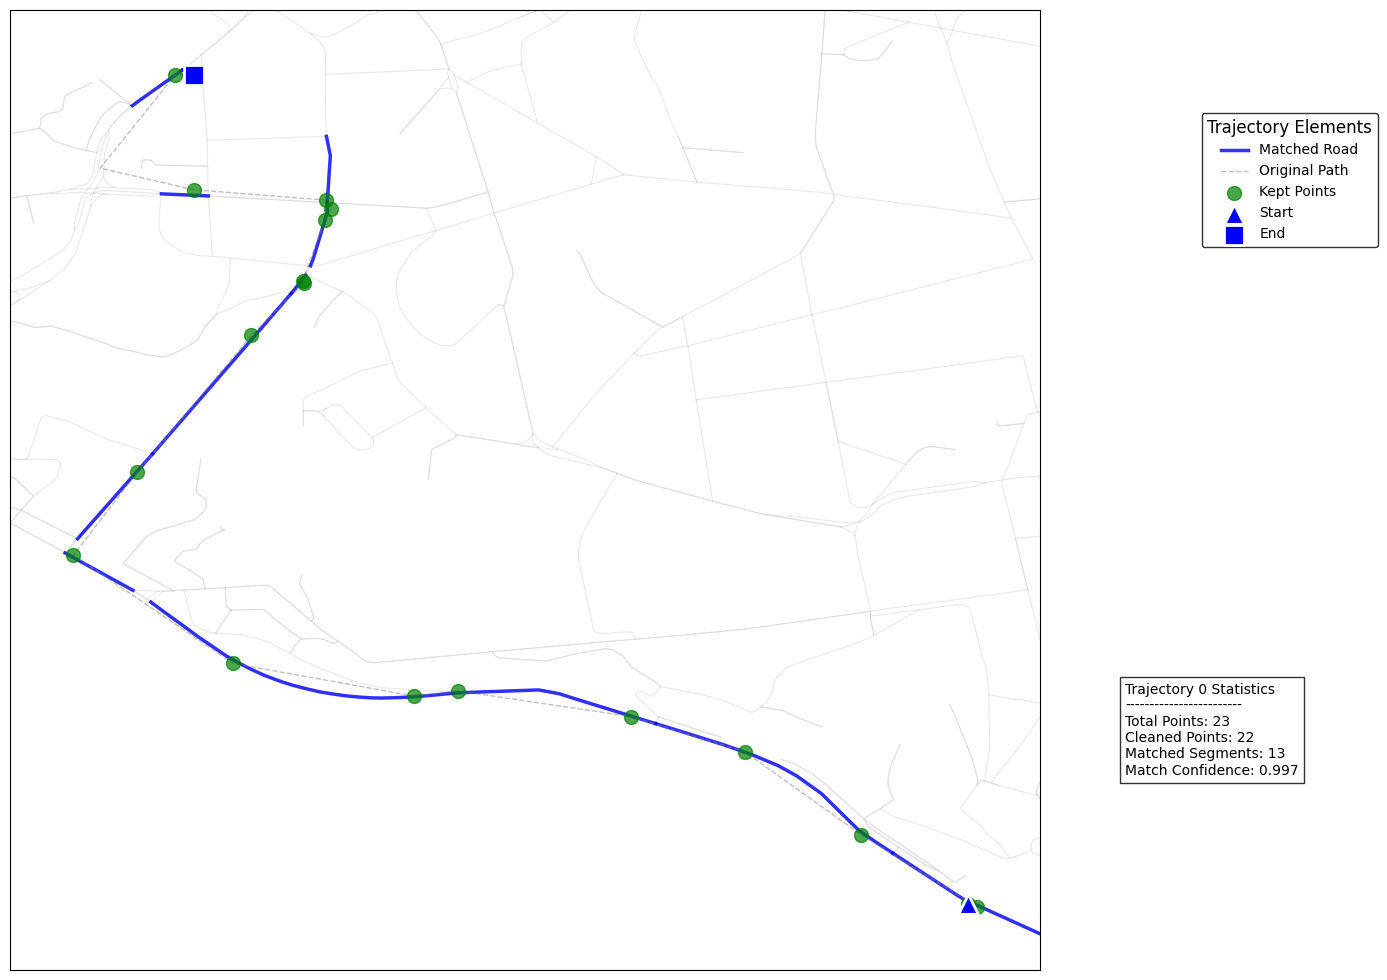

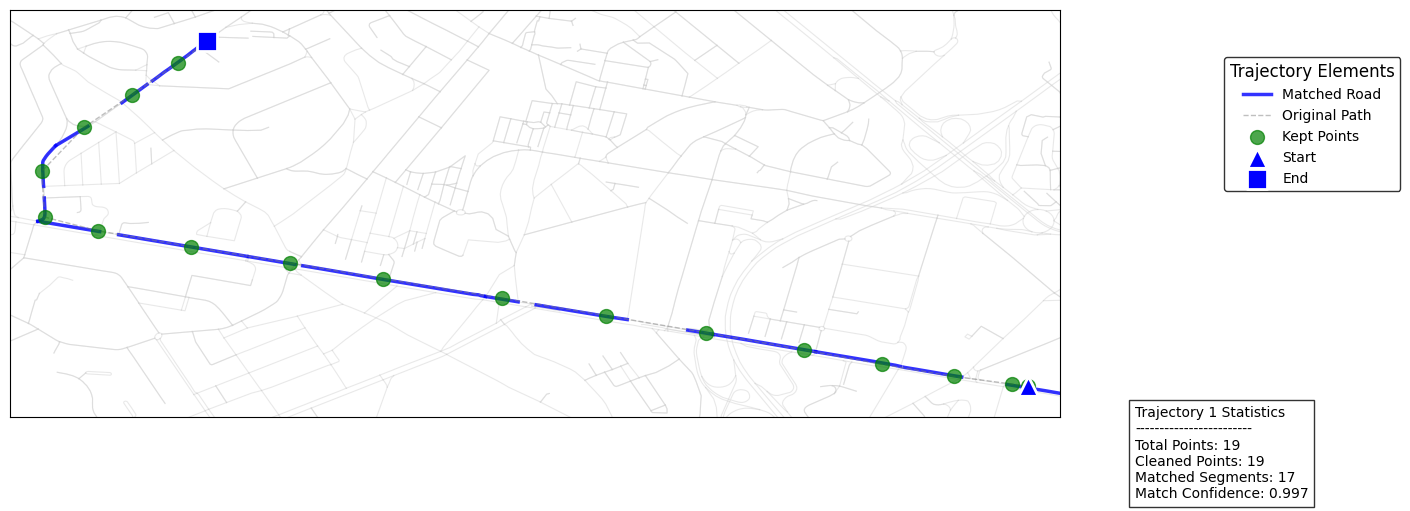

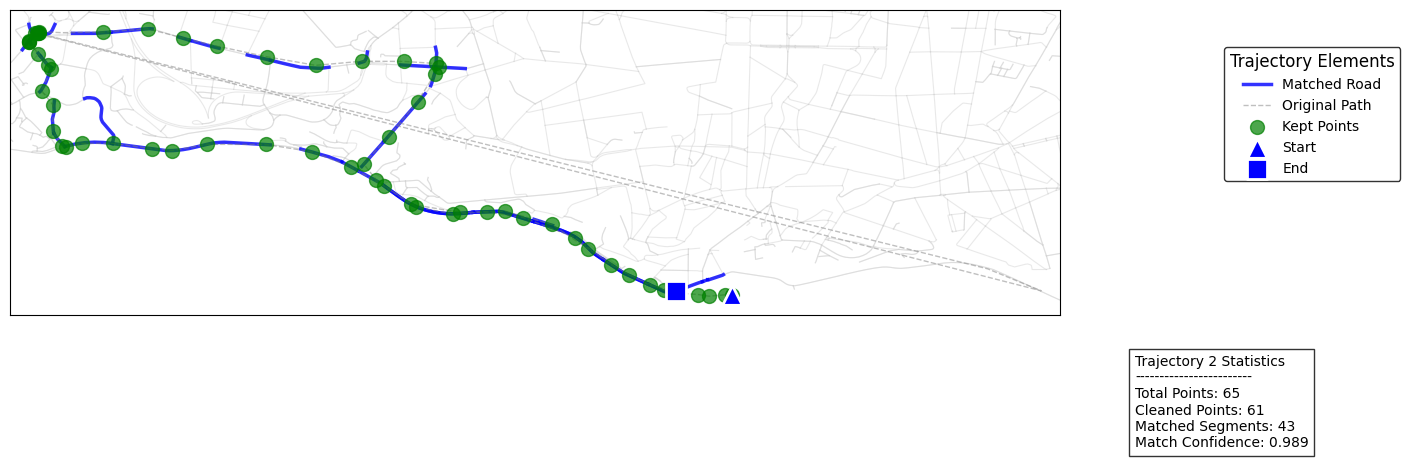

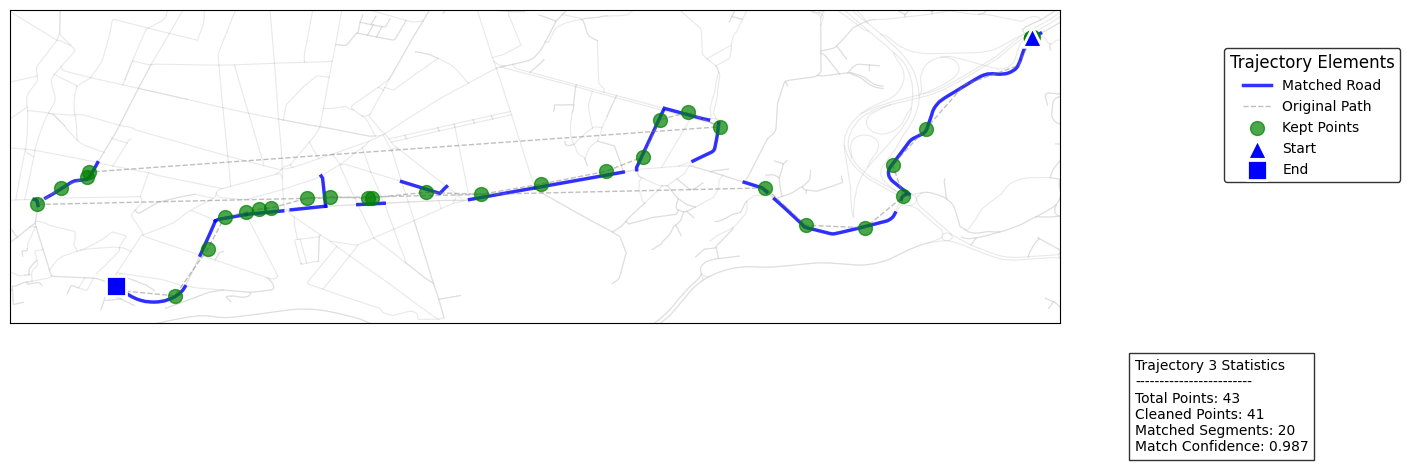

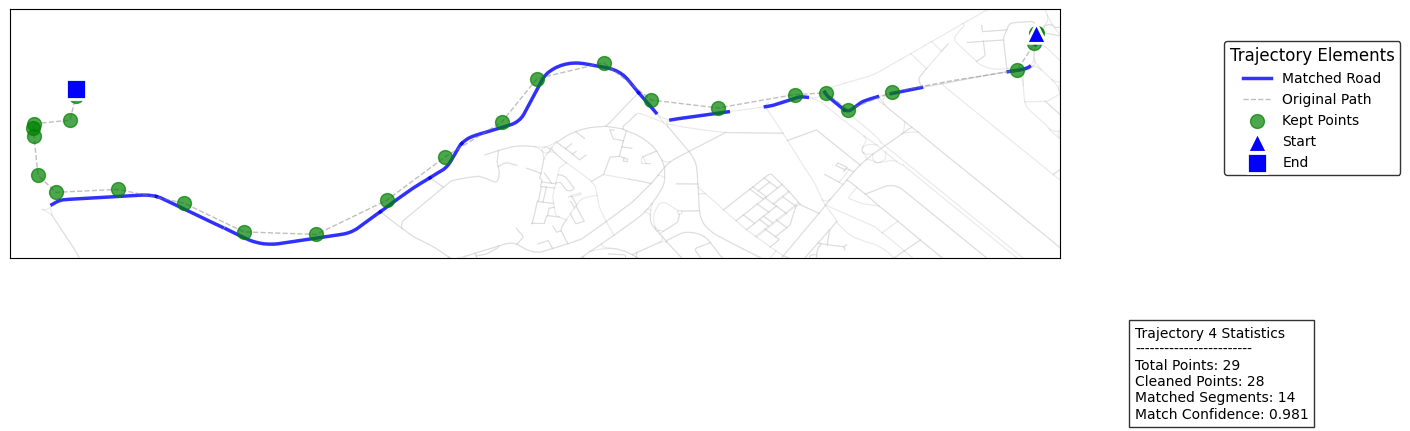

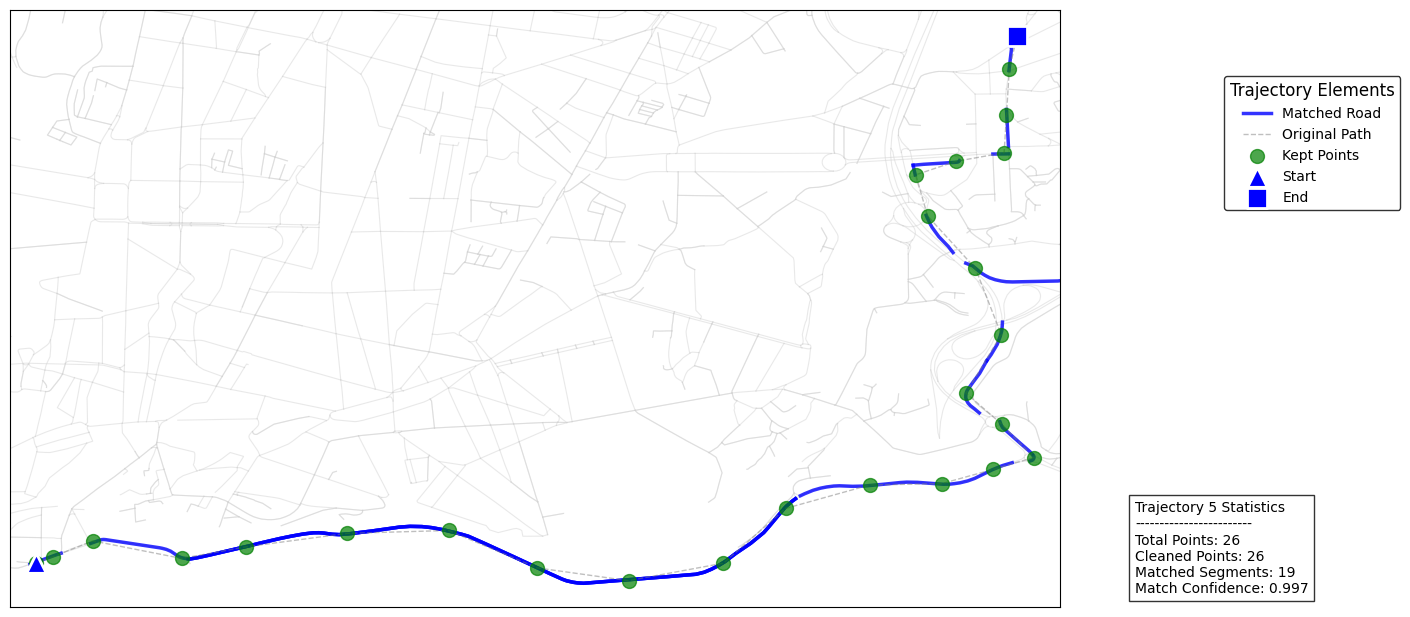

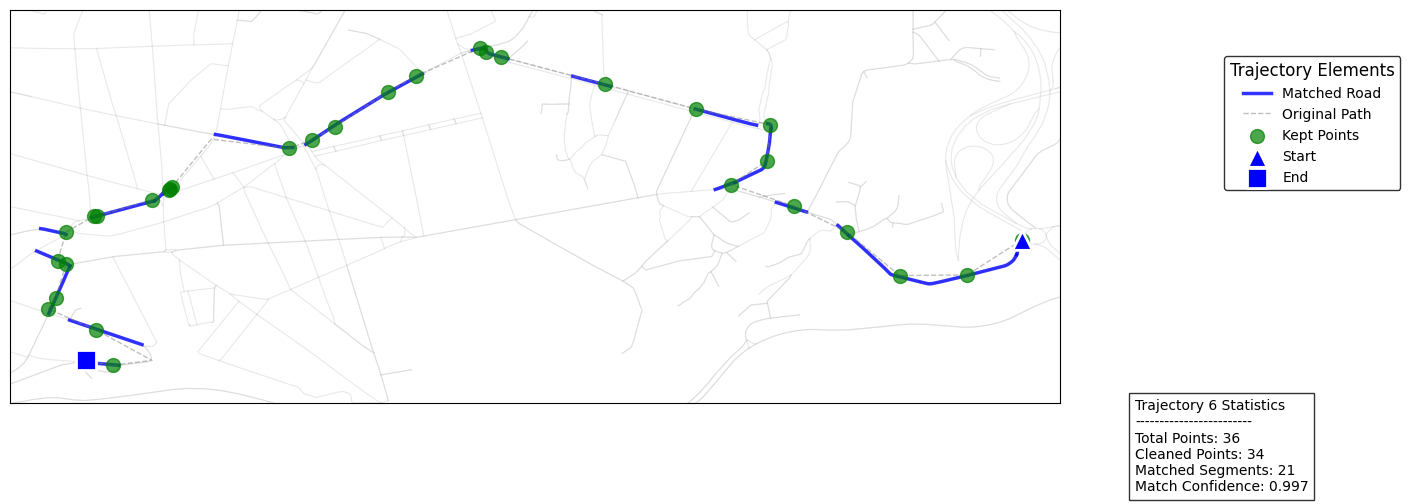

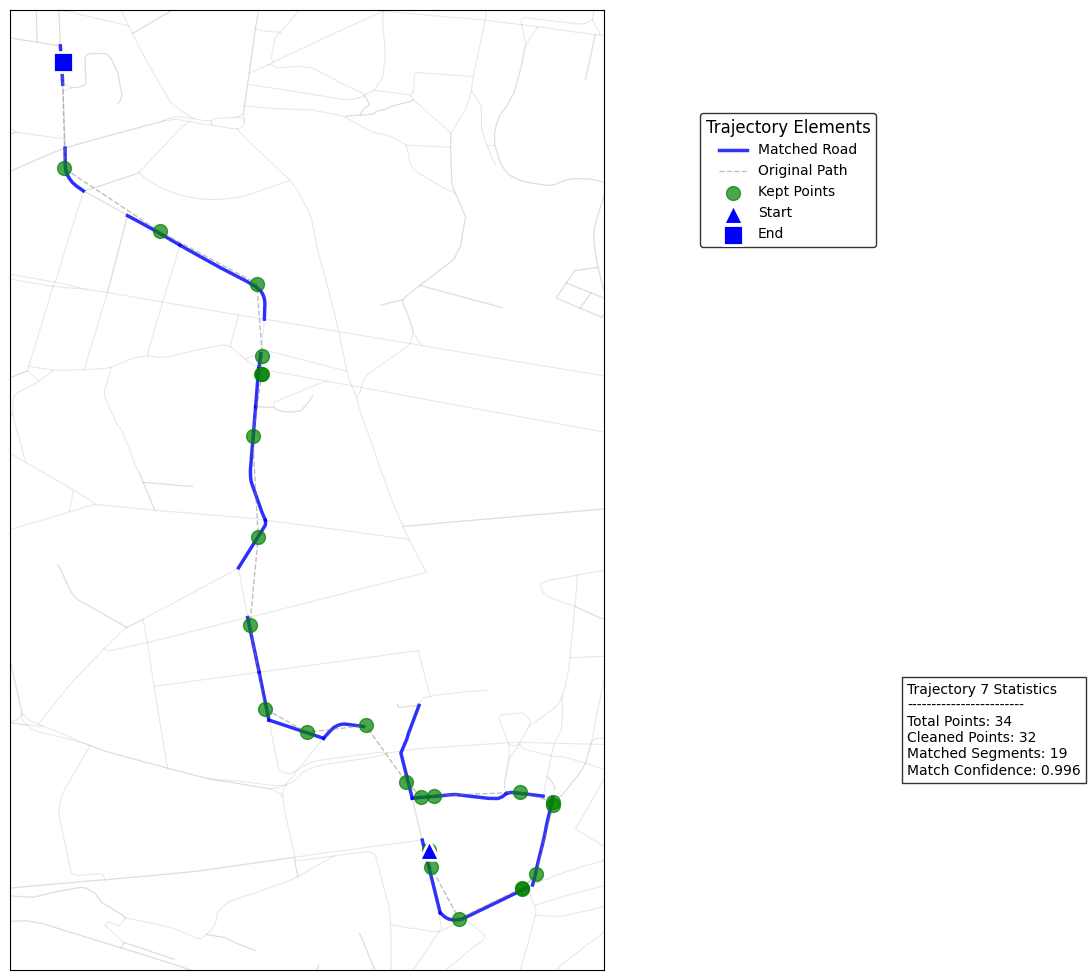

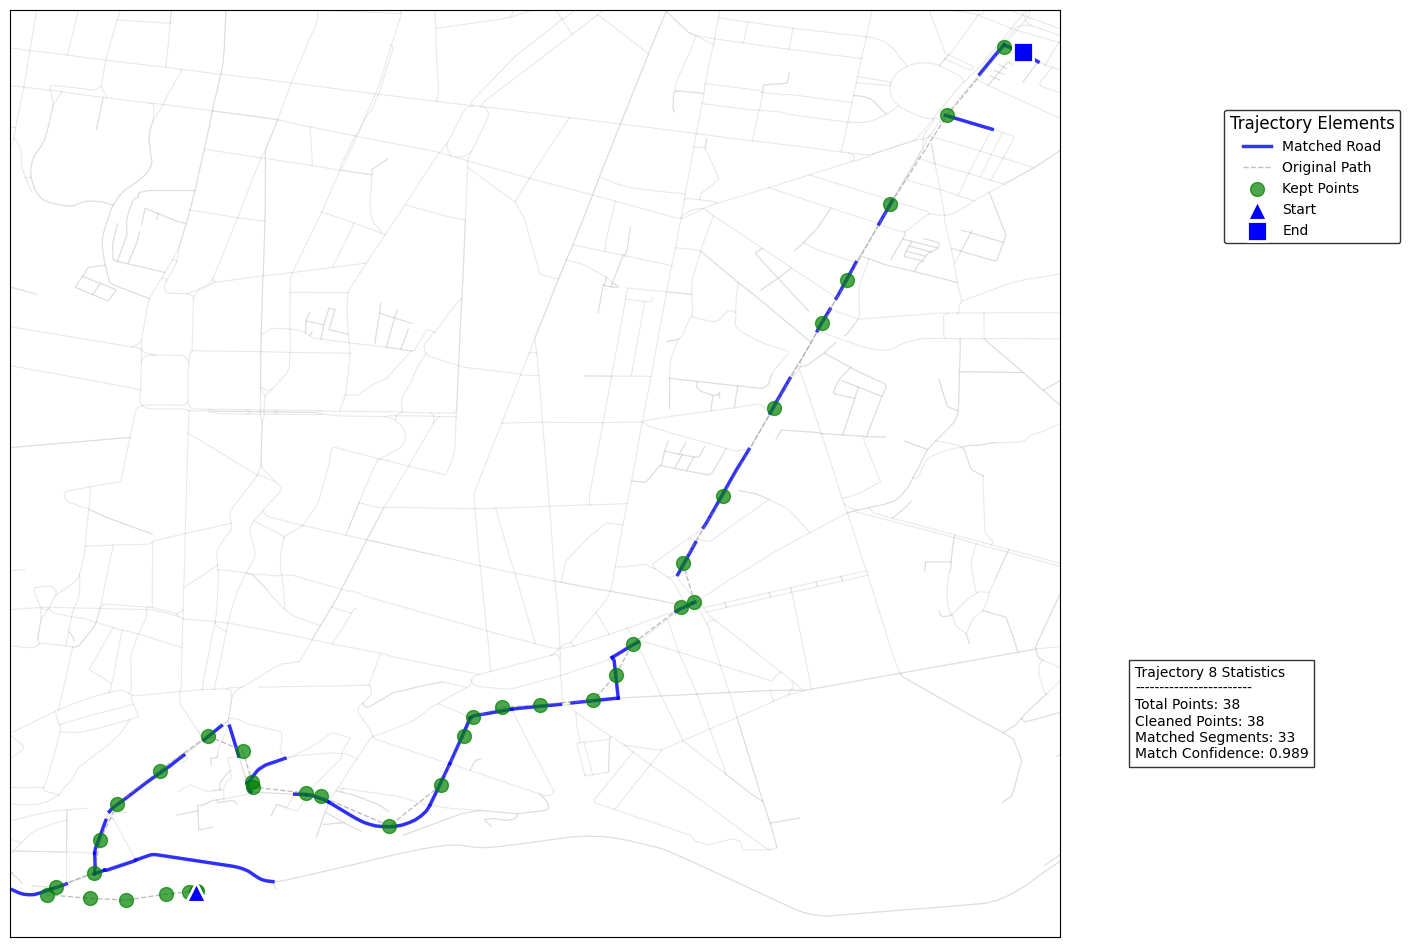

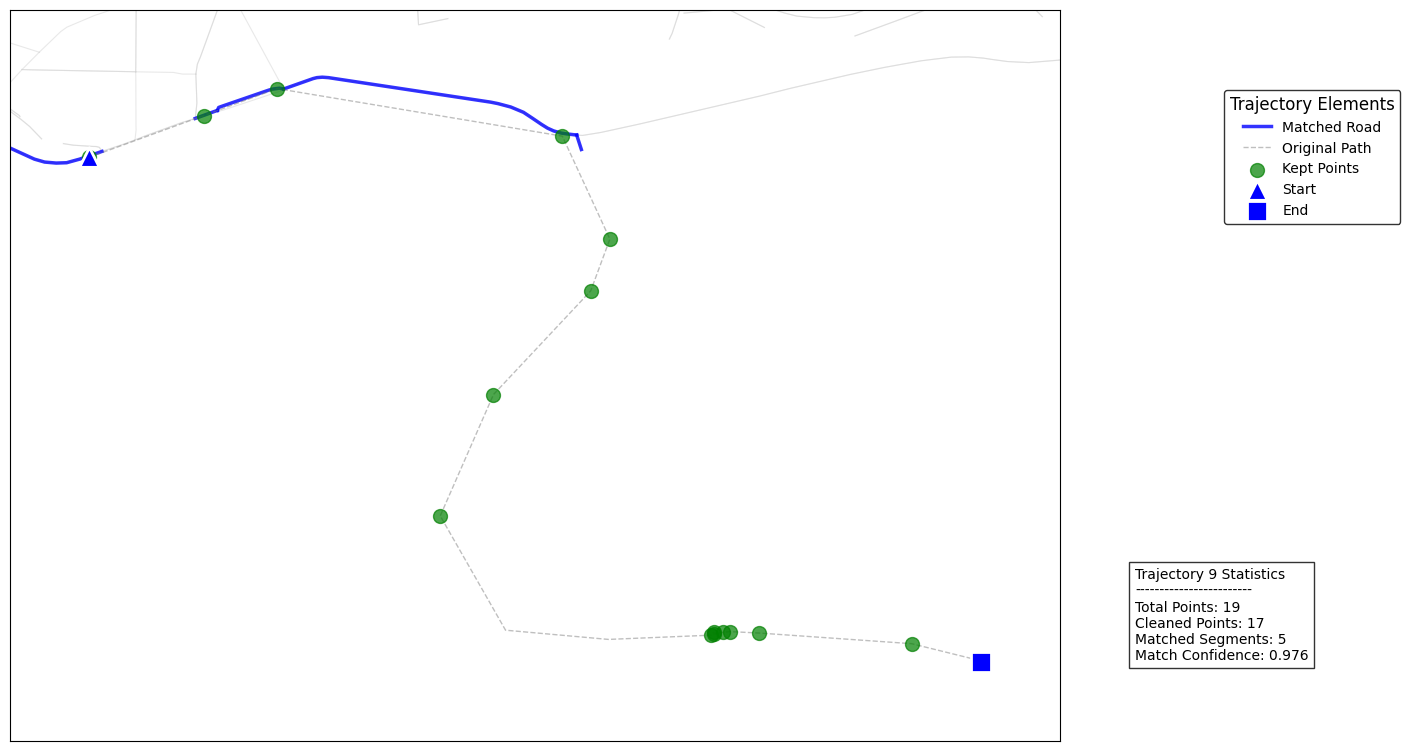

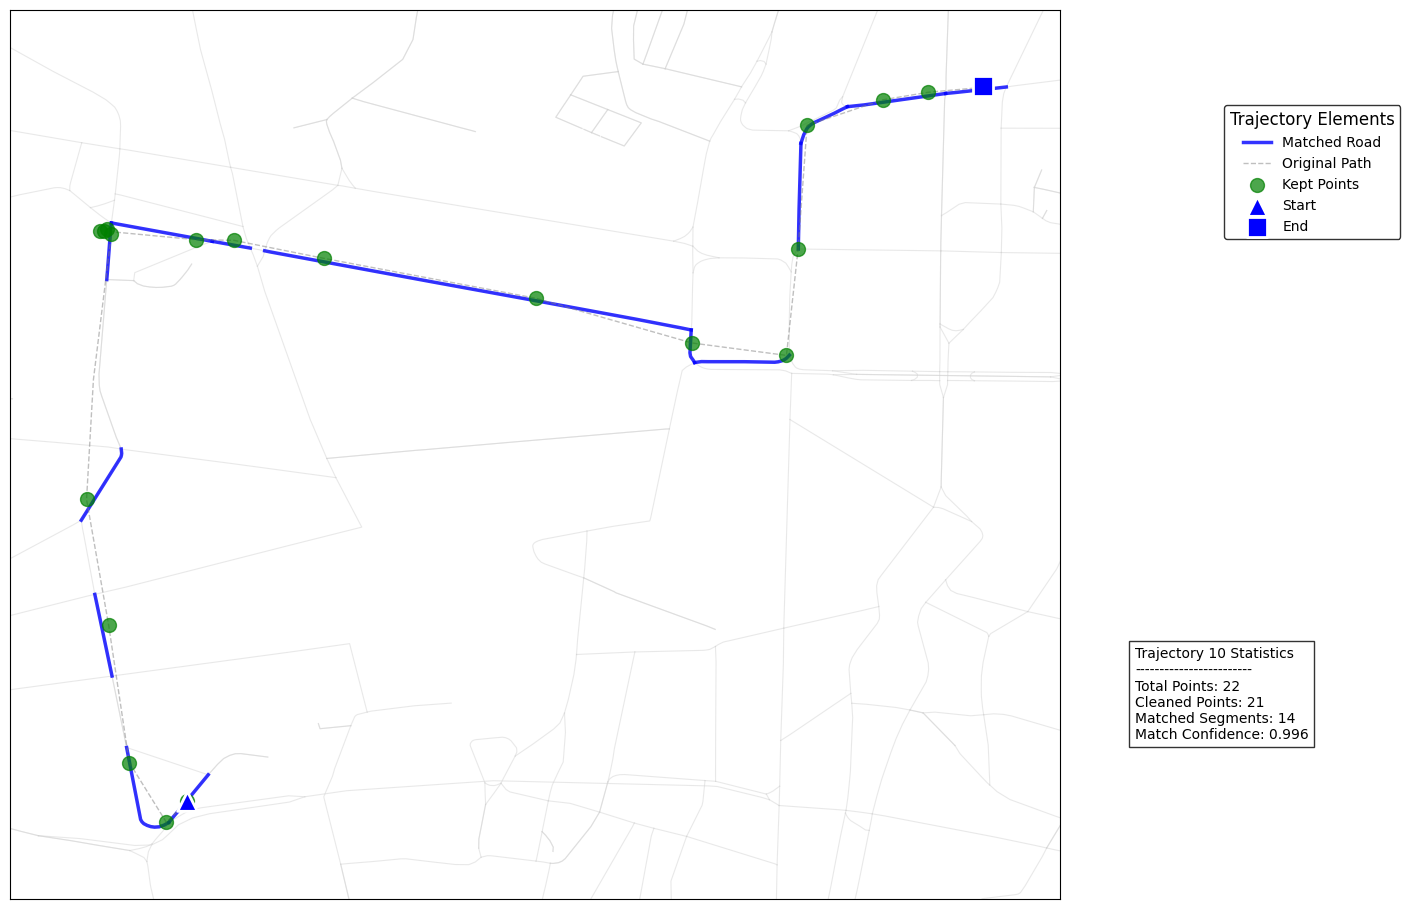

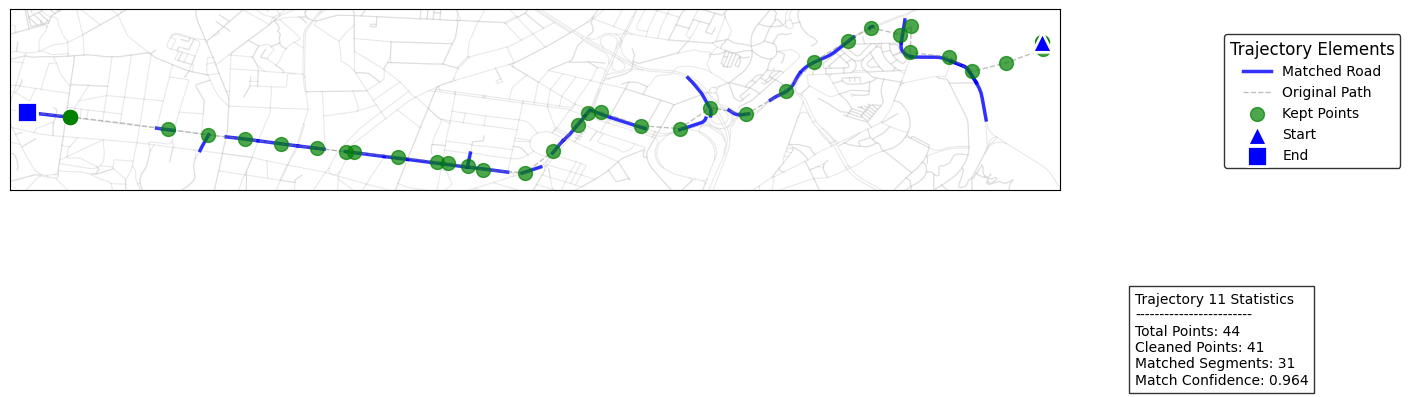

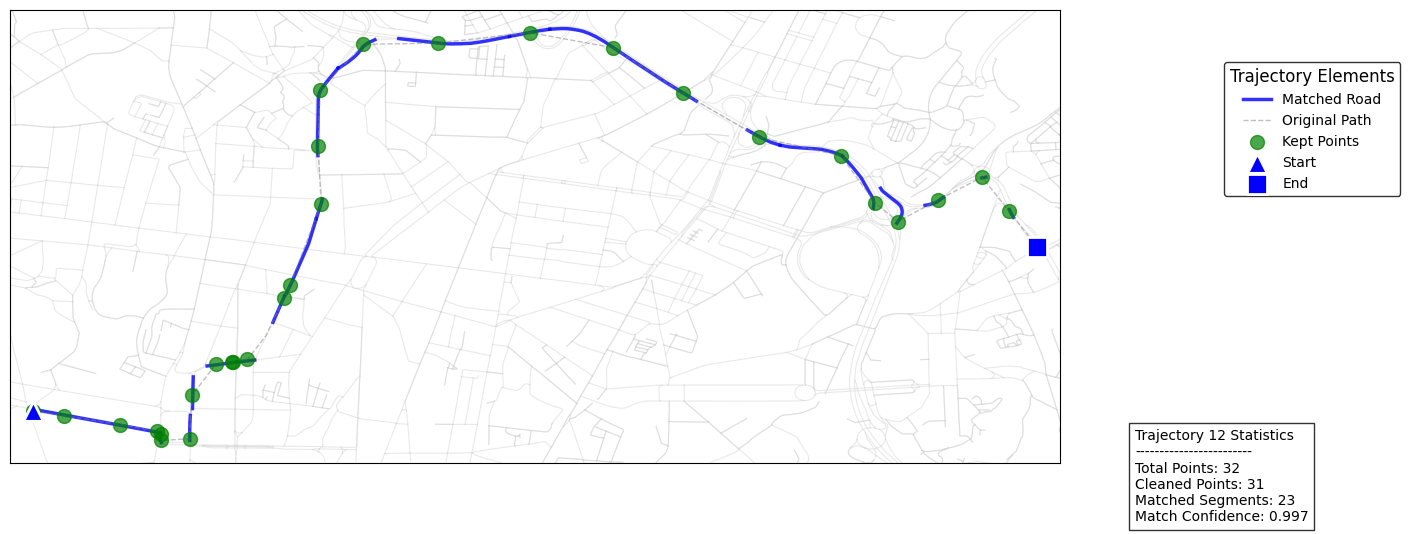

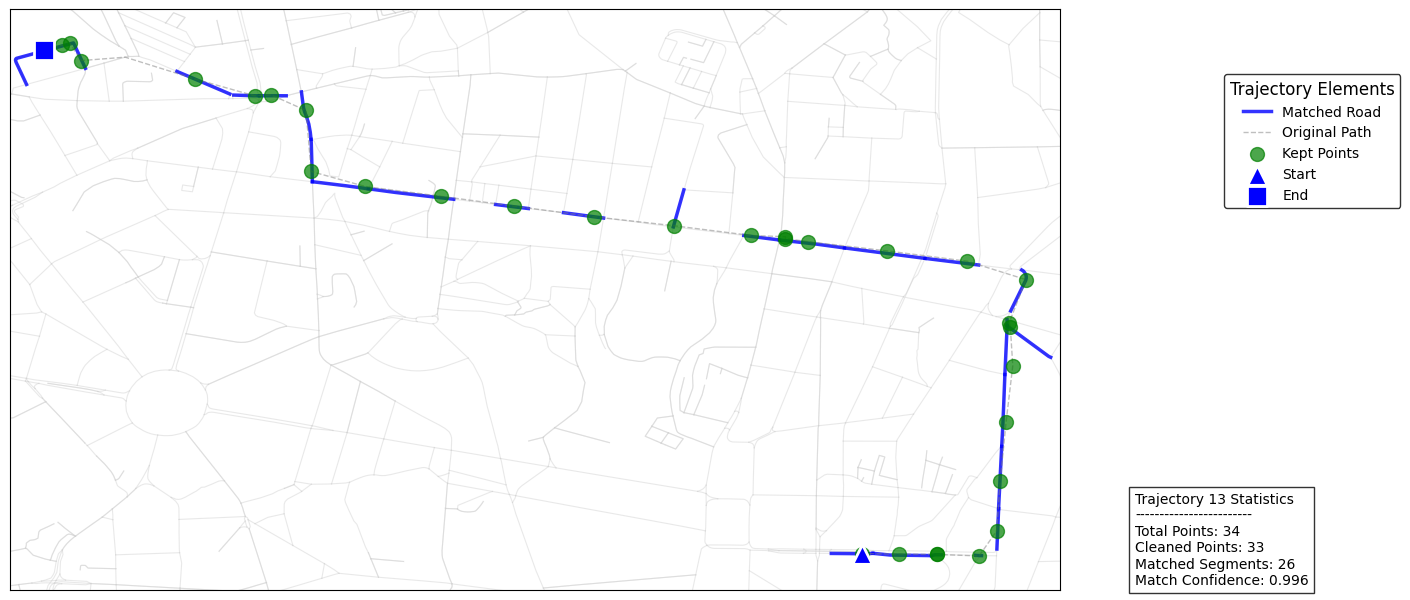

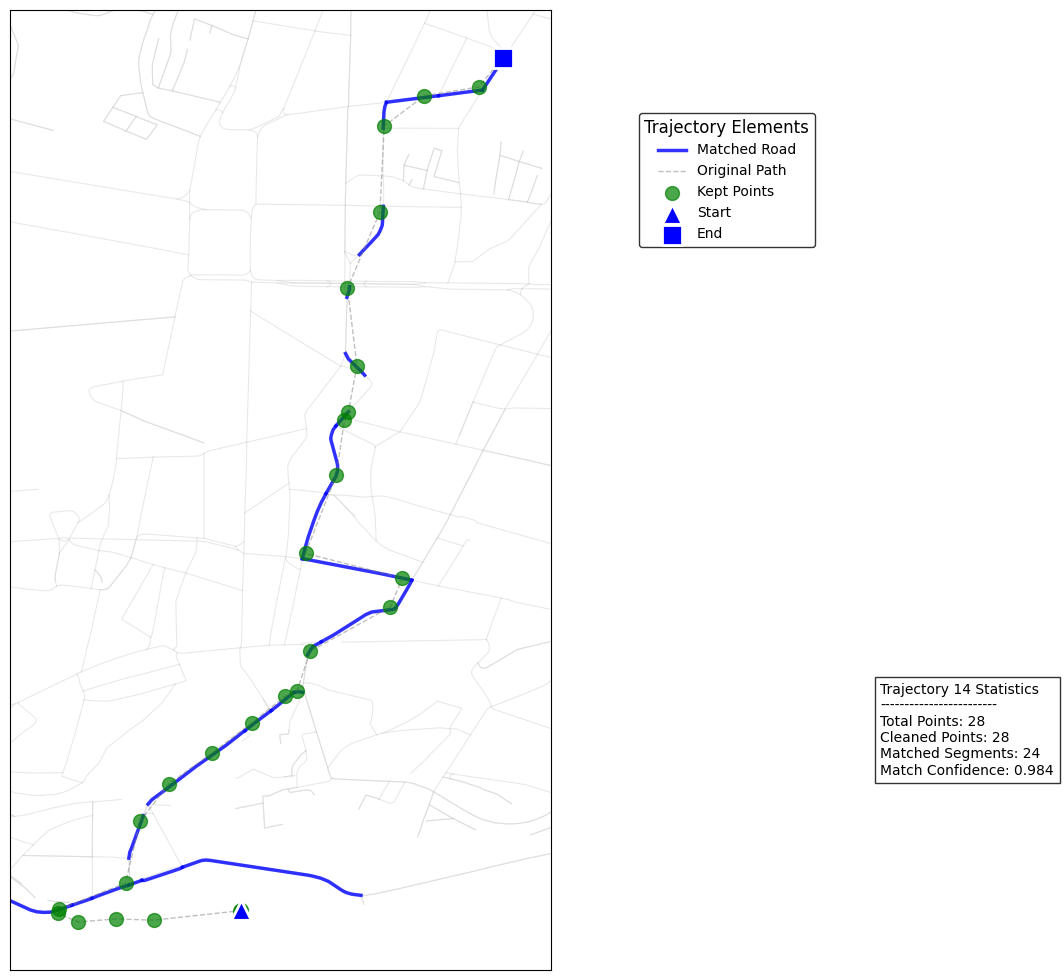

In [166]:
# def plot_mapped_trajectories(matcher, matched_results, n_plots=5):
#     """
#     Visualize mapped trajectories on the road network with detailed route information
#     """
#     if not matched_results:
#         print("No matched results to visualize")
#         return
    
#     n_plots = min(n_plots, len(matched_results))
#     fig, axs = plt.subplots(n_plots, 1, figsize=(15, 8*n_plots))
#     if n_plots == 1:
#         axs = [axs]
    
#     # Color palette for routes
#     colors = plt.cm.rainbow(np.linspace(0, 1, n_plots))
    
#     for i, result in enumerate(matched_results[:n_plots]):
#         ax = axs[i]
#         trajectory_id = result['trajectory_id']  # Use this consistently
#         match_result = result['match_result']
#         original_coords = result['original_coords']
        
#         # Plot base road network in light gray
#         matcher.edges_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3)
        
#         # Plot original GPS points
#         gps_lons, gps_lats = zip(*original_coords)
#         ax.scatter(gps_lons, gps_lats, c='red', s=20, alpha=0.5, label='GPS Points')
        
#         # Collect all coordinates for bounds calculation
#         all_lons = list(gps_lons)
#         all_lats = list(gps_lats)
        
#         # Plot matched route
#         if match_result['edges']:
#             # Create a continuous route from matched edges
#             route_coords = []
#             for edge_idx in match_result['edges']:
#                 edge = matcher.edges_gdf.iloc[edge_idx]
#                 coords = list(edge.geometry.coords)
#                 route_coords.extend(coords)
            
#             if route_coords:
#                 # Add route coordinates to bounds calculation
#                 route_lons, route_lats = zip(*route_coords)
#                 all_lons.extend(route_lons)
#                 all_lats.extend(route_lats)
                
#                 # Plot the route
#                 ax.plot(route_lons, route_lats, 
#                        c=colors[i], linewidth=2.5, alpha=0.8,
#                        label=f'Matched Route (#{trajectory_id})')
                
#                 # Mark start and end points
#                 ax.scatter(route_coords[0][0], route_coords[0][1], 
#                           c='green', marker='^', s=100, 
#                           label='Start', zorder=5)
#                 ax.scatter(route_coords[-1][0], route_coords[-1][1], 
#                           c='red', marker='s', s=100, 
#                           label='End', zorder=5)
        
#         # Add route information - Using trajectory_id consistently
#         info_text = f'Trajectory #{trajectory_id}\n'
#         info_text += f'Confidence: {match_result["confidence"]:.3f}\n'
#         info_text += f'Matched Segments: {len(match_result["edges"])}\n'
#         info_text += f'Original Points: {len(original_coords)}'
        
#         # Add text box with route information
#         ax.text(0.02, 0.98, info_text,
#                 transform=ax.transAxes,
#                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
#                 verticalalignment='top',
#                 fontsize=10)
        
#         # Customize plot
#         ax.set_title(f'Trajectory #{trajectory_id} Map Matching Result')
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#         ax.axis('equal')
#         ax.grid(True, alpha=0.3)
        
#         # Calculate and set bounds
#         bound_padding = 0.002  # Approximately 200m at typical latitudes
#         minx, maxx = min(all_lons), max(all_lons)
#         miny, maxy = min(all_lats), max(all_lats)
#         width = maxx - minx
#         height = maxy - miny
        
#         ax.set_xlim([minx - width*bound_padding, maxx + width*bound_padding])
#         ax.set_ylim([miny - height*bound_padding, maxy + height*bound_padding])
    
#     plt.tight_layout()
#     plt.savefig('mapped_trajectories.png', 
#                 dpi=300, 
#                 bbox_inches='tight',
#                 facecolor='white')
#     plt.show()

# def analyze_route_statistics(matcher, matched_results):
#     """
#     Analyze and display statistics for mapped routes
    
#     Args:
#         matcher: ImprovedMapMatcher instance
#         matched_results: List of matched trajectory results
#     """
#     stats = []
#     for result in matched_results:
#         trajectory_id = result['trajectory_id']
#         match_result = result['match_result']
#         original_coords = result['original_coords']
        
#         # Calculate route length
#         route_length = 0
#         if match_result['edges']:
#             for edge_idx in match_result['edges']:
#                 edge = matcher.edges_gdf.iloc[edge_idx]
#                 route_length += edge.geometry.length
        
#         # Calculate original path length
#         orig_length = 0
#         for i in range(len(original_coords)-1):
#             p1 = Point(original_coords[i])
#             p2 = Point(original_coords[i+1])
#             orig_length += p1.distance(p2)
        
#         stats.append({
#             'trajectory_id': trajectory_id,
#             'num_segments': len(match_result['edges']),
#             'num_points': len(original_coords),
#             'confidence': match_result['confidence'],
#             'route_length': route_length,
#             'original_length': orig_length,
#             'length_ratio': route_length/orig_length if orig_length > 0 else 0
#         })
    
#     stats_df = pd.DataFrame(stats)
#     print("\nRoute Statistics Summary:")
#     print("=" * 50)
#     print(f"Total Trajectories: {len(stats_df)}")
#     print(f"Average Segments per Route: {stats_df['num_segments'].mean():.1f}")
#     print(f"Average Confidence: {stats_df['confidence'].mean():.3f}")
#     print(f"Average Length Ratio: {stats_df['length_ratio'].mean():.2f}")
    
#     return stats_df







# def plot_single_trajectory(matcher, matched_results, trajectory_idx):
#     """
#     Plot a single trajectory with enhanced validation and visualization
#     Args:
#         matcher: ImprovedMapMatcher instance
#         matched_results: List of matching results
#         trajectory_idx: Index of trajectory to plot
#     """
#     # Validate inputs
#     if not matched_results:
#         print("No matched results to visualize")
#         return
    
#     # Find the specified trajectory with validation
#     trajectory = None
#     for result in matched_results:
#         if result['trajectory_id'] == trajectory_idx:
#             trajectory = result
#             break
            
#     if trajectory is None:
#         print(f"Trajectory {trajectory_idx} not found!")
#         return
    
#     # Validate coordinate data
#     original_coords = trajectory['original_coords']
#     cleaned_coords = trajectory['match_result']['cleaned_coords']
#     edges = trajectory['match_result']['edges']
    
#     if not original_coords or not cleaned_coords:
#         print(f"Invalid coordinates for trajectory {trajectory_idx}")
#         return
    
#     if not edges:
#         print(f"No matched edges for trajectory {trajectory_idx}")
    
#     # Create figure with two subplots: overview and zoomed
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
#     # Plotting functions for both views
#     def plot_view(ax, zoom=False):
#         # Plot road network
#         matcher.edges_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3)
        
#         # Plot matched edges with sequential coloring
#         if edges:
#             colors = plt.cm.viridis(np.linspace(0, 1, len(edges)))
#             for i, edge_idx in enumerate(edges):
#                 try:
#                     edge = matcher.edges_gdf.iloc[edge_idx]
#                     xs, ys = edge.geometry.xy
#                     ax.plot(xs, ys, '-', color=colors[i], linewidth=2.5, alpha=0.8,
#                            label=f'Segment {i+1}' if i < 5 else "")
#                 except Exception as e:
#                     print(f"Error plotting edge {edge_idx}: {str(e)}")
        
#         # Plot trajectory points with connecting lines
#         # Original path
#         orig_lons, orig_lats = zip(*original_coords)
#         ax.plot(orig_lons, orig_lats, '--', color='gray', linewidth=1.0, 
#                 alpha=0.5, label='GPS Track')
        
#         # Plot points with temporal coloring
#         time_colors = plt.cm.coolwarm(np.linspace(0, 1, len(original_coords)))
        
#         # Plot kept points
#         clean_lons, clean_lats = zip(*cleaned_coords)
#         for i, (lon, lat) in enumerate(zip(clean_lons, clean_lats)):
#             ax.scatter(lon, lat, color=time_colors[i], s=100, alpha=0.7,
#                       marker='o', edgecolor='green')
        
#         # Find and plot outliers
#         outlier_coords = []
#         original_set = set(map(tuple, original_coords))
#         cleaned_set = set(map(tuple, cleaned_coords))
#         outlier_coords = list(original_set - cleaned_set)
        
#         if outlier_coords:
#             outlier_lons, outlier_lats = zip(*outlier_coords)
#             ax.scatter(outlier_lons, outlier_lats, color='red', marker='x',
#                       s=150, linewidth=2, label='Outliers', zorder=6)
        
#         # Highlight start and end
#         ax.scatter(original_coords[0][0], original_coords[0][1], 
#                   color='blue', marker='^', s=200, label='Start', zorder=7)
#         ax.scatter(original_coords[-1][0], original_coords[-1][1],
#                   color='blue', marker='s', s=200, label='End', zorder=7)
        
#         # Add directional arrows along the path
#         path_coords = np.array(cleaned_coords)
#         for i in range(0, len(path_coords)-1, max(1, len(path_coords)//10)):
#             mid_point = (path_coords[i] + path_coords[i+1]) / 2
#             dx = path_coords[i+1][0] - path_coords[i][0]
#             dy = path_coords[i+1][1] - path_coords[i][1]
#             ax.arrow(mid_point[0], mid_point[1], dx/10, dy/10,
#                     head_width=0.0001, head_length=0.0002, fc='k', ec='k')
        
#         # Set appropriate zoom level
#         if zoom:
#             # Calculate dynamic padding based on trajectory size
#             points = np.vstack((cleaned_coords, outlier_coords if outlier_coords else []))
#             center = np.mean(points, axis=0)
#             std_dev = np.std(points, axis=0)
#             padding = std_dev * 2
            
#             ax.set_xlim([center[0] - padding[0], center[0] + padding[0]])
#             ax.set_ylim([center[1] - padding[1], center[1] + padding[1]])
#         else:
#             # Show full extent with padding
#             all_coords = np.vstack((original_coords, 
#                                   [edge.geometry.coords[:] for edge_idx in edges 
#                                    for edge in [matcher.edges_gdf.iloc[edge_idx]]]))
#             min_coords = np.min(all_coords, axis=0)
#             max_coords = np.max(all_coords, axis=0)
#             padding = (max_coords - min_coords) * 0.1
            
#             ax.set_xlim([min_coords[0] - padding[0], max_coords[0] + padding[0]])
#             ax.set_ylim([min_coords[1] - padding[1], max_coords[1] + padding[1]])
    
#     # Plot both views
#     plot_view(ax1, zoom=False)
#     plot_view(ax2, zoom=True)
    
#     # Customize subplots
#     ax1.set_title("Full Trajectory View")
#     ax2.set_title("Zoomed Detail View")
    
#     # Add detailed statistics
#     stats_text = (
#         f'Trajectory Statistics:\n'
#         f'Original points: {len(original_coords)}\n'
#         f'Cleaned points: {len(cleaned_coords)}\n'
#         f'Outliers removed: {len(original_coords) - len(cleaned_coords)}\n'
#         f'Matched segments: {len(edges)}\n'
#         f'Confidence: {trajectory["match_result"]["confidence"]:.3f}\n'
#         f'Average point spacing: {np.mean([np.linalg.norm(np.array(cleaned_coords[i+1]) - np.array(cleaned_coords[i])) for i in range(len(cleaned_coords)-1)]):.5f} degrees'
#     )
    
#     plt.figtext(1.02, 0.5, stats_text, fontsize=10, 
#                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    
#     plt.tight_layout()
#     plt.savefig(f'trajectory_{trajectory_idx}_detailed.png',
#                 dpi=300, bbox_inches='tight', facecolor='white')
#     plt.show()
    
#     # Return validation info
#     return {
#         'valid_edges': all(0 <= idx < len(matcher.edges_gdf) for idx in edges),
#         'point_counts': {
#             'original': len(original_coords),
#             'cleaned': len(cleaned_coords),
#             'outliers': len(original_coords) - len(cleaned_coords)
#         },
#         'edge_count': len(edges),
#         'confidence': trajectory["match_result"]["confidence"]
#     }












# def plot_single_trajectory(matcher, matched_results, trajectory_idx):
#     """Plot a single trajectory showing original, cleaned, and outlier points"""
#     # Find the specified trajectory
#     trajectory = None
#     for result in matched_results:
#         if result['trajectory_id'] == trajectory_idx:
#             trajectory = result
#             break
            
#     if trajectory is None:
#         print(f"Trajectory {trajectory_idx} not found!")
#         return
        
#     # Get coordinates
#     original_coords = trajectory['original_coords']
#     cleaned_coords = trajectory['match_result']['cleaned_coords']
    
#     # Find outlier points by comparing original and cleaned coordinates
#     outlier_coords = []
#     original_set = set(map(tuple, original_coords))
#     cleaned_set = set(map(tuple, cleaned_coords))
#     outlier_coords = list(original_set - cleaned_set)
    
#     # Print statistics
#     print(f"\nTrajectory {trajectory_idx} Statistics:")
#     print(f"Original points: {len(original_coords)}")
#     print(f"Points after cleaning: {len(cleaned_coords)}")
#     print(f"Points removed (outliers): {len(outlier_coords)}")
#     print(f"Number of matched edges: {len(trajectory['match_result']['edges'])}")
#     print(f"Matching confidence: {trajectory['match_result']['confidence']:.4f}")
    
#     # Calculate bounding box
#     all_lons = [p[0] for p in original_coords]
#     all_lats = [p[1] for p in original_coords]
    
#     # Get bounds with padding
#     bound_padding = 0.002
#     minx, maxx = min(all_lons), max(all_lons)
#     miny, maxy = min(all_lats), max(all_lats)
#     width = maxx - minx
#     height = maxy - miny
#     minx -= width * bound_padding
#     maxx += width * bound_padding
#     miny -= height * bound_padding
#     maxy += height * bound_padding
    
#     # Create figure
#     fig, ax = plt.subplots(figsize=(15, 15))
    
#     # Plot road network
#     ox.plot_graph(
#         matcher.graph,
#         ax=ax,
#         bgcolor='white',
#         node_size=0,
#         edge_color='black',
#         edge_linewidth=0.8,
#         edge_alpha=0.5,
#         show=False,
#         close=False
#     )
    
#     # Plot matched edges
#     for edge_idx in trajectory['match_result']['edges']:
#         edge = matcher.edges_gdf.iloc[edge_idx]
#         ax.plot(*edge.geometry.xy, '-',
#                color='blue', linewidth=2.5, alpha=0.6,
#                zorder=2, label='Matched Road Segments' if edge_idx == trajectory['match_result']['edges'][0] else "")
    
#     # Plot original trajectory path
#     orig_lons, orig_lats = zip(*original_coords)
#     ax.plot(orig_lons, orig_lats, '--',
#            color='gray', linewidth=1.0, alpha=0.5,
#            label='Original Path',
#            zorder=3)
    
#     # Plot kept points
#     clean_lons, clean_lats = zip(*cleaned_coords)
#     ax.scatter(clean_lons, clean_lats,
#               color='green', s=100, alpha=0.7,
#               label='Kept Points', zorder=5)
    
#     # Plot outlier points with red X markers
#     if outlier_coords:
#         outlier_lons, outlier_lats = zip(*outlier_coords)
#         ax.scatter(outlier_lons, outlier_lats,
#                   color='red', marker='x', s=150, linewidth=2,
#                   label='Outlier Points', zorder=6)
        
#         # Add connecting lines to outliers to show their sequence
#         for i in range(len(original_coords)-1):
#             if original_coords[i] in outlier_coords or original_coords[i+1] in outlier_coords:
#                 ax.plot([original_coords[i][0], original_coords[i+1][0]],
#                        [original_coords[i][1], original_coords[i+1][1]],
#                        'r:', linewidth=1, alpha=0.5, zorder=4)
    
#     # Plot start and end points
#     ax.scatter(cleaned_coords[0][0], cleaned_coords[0][1], 
#               color='blue', marker='^', s=150,
#               label='Start', zorder=7)
#     ax.scatter(cleaned_coords[-1][0], cleaned_coords[-1][1],
#               color='blue', marker='s', s=150,
#               label='End', zorder=7)
    
#     # Set limits and styling
#     ax.set_xlim([minx, maxx])
#     ax.set_ylim([miny, maxy])
#     ax.set_axis_off()
    
#     # Enhanced legend with outlier information
#     legend = ax.legend(
#         loc='center left',
#         bbox_to_anchor=(1, 0.5),
#         title=f'Trajectory {trajectory_idx}\n'
#               f'Confidence: {trajectory["match_result"]["confidence"]:.2f}\n'
#               f'Total Points: {len(original_coords)}\n'
#               f'Outliers: {len(outlier_coords)}',
#         fontsize=10,
#         markerscale=1,
#         frameon=True,
#         facecolor='white',
#         edgecolor='black'
#     )
#     legend.get_title().set_fontsize('12')
    
#     plt.tight_layout()
#     plt.savefig(
#         f'trajectory_{trajectory_idx}_comparison.png',
#         dpi=300,
#         bbox_inches='tight',
#         facecolor='white',
#         edgecolor='none',
#         pad_inches=0.5
#     )
#     plt.show()

# def plot_single_trajectory_improved(matcher, matched_results, trajectory_idx, 
#                                   save_path=None, figsize=(15, 15)):
#     """
#     Enhanced visualization of a single trajectory focused on road network mapping.
#     Removes building footprints and simplifies the visualization.
    
#     Args:
#         matcher: ImprovedMapMatcher instance
#         matched_results: List of matching results
#         trajectory_idx: Index of trajectory to visualize
#         save_path: Optional path to save the plot
#         figsize: Figure size tuple (width, height)
#     """
#     # Find the specified trajectory
#     trajectory = None
#     for result in matched_results:
#         if result['trajectory_id'] == trajectory_idx:
#             trajectory = result
#             break
            
#     if trajectory is None:
#         print(f"Trajectory {trajectory_idx} not found!")
#         return
        
#     # Extract coordinates and matching results
#     original_coords = np.array(trajectory['original_coords'])
#     cleaned_coords = np.array(trajectory['match_result']['cleaned_coords'])
#     matched_edges = trajectory['match_result']['edges']
    
#     # Find outlier points
#     original_set = set(map(tuple, original_coords))
#     cleaned_set = set(map(tuple, cleaned_coords))
#     outlier_coords = np.array(list(original_set - cleaned_set))
    
#     # Calculate dynamic padding based on trajectory characteristics
#     all_points = np.vstack([original_coords, outlier_coords]) if len(outlier_coords) > 0 else original_coords
#     std_dev = np.std(all_points, axis=0)
#     center = np.mean(all_points, axis=0)
    
#     # Dynamic padding based on trajectory size and spread
#     bound_padding = std_dev * 0.3
    
#     # Calculate bounds with dynamic padding
#     minx = center[0] - (std_dev[0] * 2 + bound_padding[0])
#     maxx = center[0] + (std_dev[0] * 2 + bound_padding[0])
#     miny = center[1] - (std_dev[1] * 2 + bound_padding[1])
#     maxy = center[1] + (std_dev[1] * 2 + bound_padding[1])
    
#     # Create figure and axes
#     fig, ax = plt.subplots(figsize=figsize)
    
#     # Plot road network - simplified style
#     for _, edge in matcher.edges_gdf.iterrows():
#         ax.plot(*edge.geometry.xy, 
#                 color='lightgray',
#                 linewidth=0.8,
#                 alpha=0.5,
#                 zorder=1)
    
#     # Plot matched edges in blue
#     for i, edge_idx in enumerate(matched_edges):
#         edge = matcher.edges_gdf.iloc[edge_idx]
#         ax.plot(*edge.geometry.xy, '-',
#                 color='blue', 
#                 linewidth=2.5, 
#                 alpha=0.6,
#                 zorder=2, 
#                 label='Matched Road' if i == 0 else "")
    
#     # Plot original trajectory path
#     ax.plot(original_coords[:, 0], original_coords[:, 1],
#             '--',
#             color='gray',
#             linewidth=1.0,
#             alpha=0.5,
#             zorder=3,
#             label='Original Path')
    
#     # Plot kept points
#     ax.scatter(cleaned_coords[:, 0], cleaned_coords[:, 1],
#               color='green',
#               s=100, alpha=0.7,
#               label='Kept Points',
#               zorder=5)
    
#     # Plot outlier points
#     if len(outlier_coords) > 0:
#         ax.scatter(outlier_coords[:, 0], outlier_coords[:, 1],
#                   color='red', marker='x', s=150, linewidth=2,
#                   label=f'Outliers ({len(outlier_coords)})',
#                   zorder=6)
        
#         # Add light connecting lines to show outlier sequence
#         for i in range(len(original_coords)-1):
#             if tuple(original_coords[i]) in original_set - cleaned_set or \
#                tuple(original_coords[i+1]) in original_set - cleaned_set:
#                 ax.plot([original_coords[i][0], original_coords[i+1][0]],
#                        [original_coords[i][1], original_coords[i+1][1]],
#                        'r:', linewidth=1, alpha=0.3, zorder=4)
    
#     # Plot start and end points
#     ax.scatter(cleaned_coords[0][0], cleaned_coords[0][1],
#               color='blue', marker='^', s=200, edgecolor='white',
#               linewidth=2, label='Start', zorder=7)
#     ax.scatter(cleaned_coords[-1][0], cleaned_coords[-1][1],
#               color='blue', marker='s', s=200, edgecolor='white',
#               linewidth=2, label='End', zorder=7)
    
#     # Add statistics text box
#     stats_text = (
#         f'Trajectory {trajectory_idx} Statistics\n'
#         f'------------------------\n'
#         f'Total Points: {len(original_coords)}\n'
#         f'Cleaned Points: {len(cleaned_coords)}\n'
#         f'Outliers Removed: {len(outlier_coords)}\n'
#         f'Matched Segments: {len(matched_edges)}\n'
#         f'Match Confidence: {trajectory["match_result"]["confidence"]:.3f}\n'
#         f'Avg Point Spacing: {np.mean([np.linalg.norm(cleaned_coords[i+1] - cleaned_coords[i]) for i in range(len(cleaned_coords)-1)]):.5f} degrees'
#     )
    
#     # Add statistics text box with semi-transparent background
#     plt.text(1.02, 0.5, stats_text,
#              transform=ax.transAxes,
#              bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'),
#              fontsize=10,
#              verticalalignment='center')
    
#     # Set limits and styling
#     ax.set_xlim([minx, maxx])
#     ax.set_ylim([miny, maxy])
#     ax.set_axis_off()
    
#     # Add legend with comprehensive information
#     legend = ax.legend(
#         loc='center left',
#         bbox_to_anchor=(1, 0.8),
#         title='Trajectory Elements',
#         fontsize=10,
#         markerscale=1,
#         frameon=True,
#         facecolor='white',
#         edgecolor='black'
#     )
#     legend.get_title().set_fontsize('12')
    
#     # Adjust layout to prevent overlap
#     plt.tight_layout()
    
#     # Save plot if path provided
#     if save_path:
#         plt.savefig(
#             save_path,
#             dpi=300,
#             bbox_inches='tight',
#             facecolor='white',
#             edgecolor='none',
#             pad_inches=0.5
#         )
    
#     plt.show()
    
#     # Return validation metrics
#     return {
#         'total_points': len(original_coords),
#         'cleaned_points': len(cleaned_coords),
#         'outliers': len(outlier_coords),
#         'matched_segments': len(matched_edges),
#         'confidence': trajectory["match_result"]["confidence"],
#         'bounds': {
#             'minx': minx, 'maxx': maxx,
#             'miny': miny, 'maxy': maxy
#         }
#     }

def plot_single_trajectory_improved(matcher, matched_results, trajectory_idx, save_path=None, figsize=(15, 12)):
    """Enhanced visualization of a single trajectory with non-overlapping legends."""
    trajectory = next((result for result in matched_results if result['trajectory_id'] == trajectory_idx), None)
    if trajectory is None:
        print(f"Trajectory {trajectory_idx} not found!")
        return
    
    original_coords = np.array(trajectory['original_coords'])
    cleaned_coords = np.array(trajectory['match_result']['cleaned_coords'])
    matched_edges = trajectory['match_result']['edges']
    
    all_points = np.vstack([original_coords])
    min_coords = np.min(all_points, axis=0)
    max_coords = np.max(all_points, axis=0)
    padding = 0.001  # Approximately 100m at typical latitudes
    minx = min_coords[0] - padding
    maxx = max_coords[0] + padding
    miny = min_coords[1] - padding
    maxy = max_coords[1] + padding
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])
    ax.set_aspect('equal')
    
    visible_network = matcher.edges_gdf[
        (matcher.edges_gdf.geometry.bounds.minx <= maxx) &
        (matcher.edges_gdf.geometry.bounds.maxx >= minx) &
        (matcher.edges_gdf.geometry.bounds.miny <= maxy) &
        (matcher.edges_gdf.geometry.bounds.maxy >= miny)
    ]
    
    for _, edge in visible_network.iterrows():
        ax.plot(*edge.geometry.xy, color='lightgray', linewidth=0.8, alpha=0.5, zorder=1)
    
    for i, edge_idx in enumerate(matched_edges):
        edge = matcher.edges_gdf.iloc[edge_idx]
        ax.plot(*edge.geometry.xy, '-', color='blue', linewidth=2.5, alpha=0.8, zorder=2, label='Matched Road' if i == 0 else "")
    
    ax.plot(original_coords[:, 0], original_coords[:, 1], '--', color='gray', linewidth=1.0, alpha=0.5, zorder=3, label='Original Path')
    ax.scatter(cleaned_coords[:, 0], cleaned_coords[:, 1], color='green', s=100, alpha=0.7, label='Kept Points', zorder=5)
    ax.scatter(cleaned_coords[0][0], cleaned_coords[0][1], color='blue', marker='^', s=200, edgecolor='white', linewidth=2, label='Start', zorder=7)
    ax.scatter(cleaned_coords[-1][0], cleaned_coords[-1][1], color='blue', marker='s', s=200, edgecolor='white', linewidth=2, label='End', zorder=7)
    
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    legend1 = ax.legend(bbox_to_anchor=(1.15, 0.9), loc='upper left', title='Trajectory Elements', fontsize=10, markerscale=1, frameon=True, facecolor='white', edgecolor='black')
    legend1.get_title().set_fontsize('12')
    
    stats_text = (
        f'Trajectory {trajectory_idx} Statistics\n'
        f'------------------------\n'
        f'Total Points: {len(original_coords)}\n'
        f'Cleaned Points: {len(cleaned_coords)}\n'
        f'Matched Segments: {len(matched_edges)}\n'
        f'Match Confidence: {trajectory["match_result"]["confidence"]:.3f}'
    )
    
    plt.figtext(0.85, 0.3, stats_text, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'), fontsize=10, verticalalignment='center')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', pad_inches=0.5)
    
    plt.show()
    
    return {
        'total_points': len(original_coords),
        'cleaned_points': len(cleaned_coords),
        'matched_segments': len(matched_edges),
        'confidence': trajectory["match_result"]["confidence"],
        'bounds': {
            'minx': minx, 'maxx': maxx,
            'miny': miny, 'maxy': maxy
        }
    }

# def plot_single_trajectory_improved(matcher, matched_results, trajectory_idx, 
#                                   save_path=None, figsize=(15, 12)):
#     """
#     Enhanced visualization of a single trajectory with non-overlapping legends.
    
#     Args:
#         matcher: ImprovedMapMatcher instance
#         matched_results: List of matching results
#         trajectory_idx: Index of trajectory to visualize
#         save_path: Optional path to save the plot
#         figsize: Figure size tuple (width, height)
#     """
#     # Find the specified trajectory
#     trajectory = None
#     for result in matched_results:
#         if result['trajectory_id'] == trajectory_idx:
#             trajectory = result
#             break
            
#     if trajectory is None:
#         print(f"Trajectory {trajectory_idx} not found!")
#         return
        
#     # Extract coordinates and matching results
#     original_coords = np.array(trajectory['original_coords'])
#     cleaned_coords = np.array(trajectory['match_result']['cleaned_coords'])
#     matched_edges = trajectory['match_result']['edges']
    
#     # Find outlier points
#     original_set = set(map(tuple, original_coords))
#     cleaned_set = set(map(tuple, cleaned_coords))
#     outlier_coords = np.array(list(original_set - cleaned_set))
    
#     # Calculate bounds
#     all_points = np.vstack([original_coords, outlier_coords]) if len(outlier_coords) > 0 else original_coords
#     min_coords = np.min(all_points, axis=0)
#     max_coords = np.max(all_points, axis=0)
    
#     # Add fixed padding (in degrees)
#     padding = 0.001  # Approximately 100m at typical latitudes
#     minx = min_coords[0] - padding
#     maxx = max_coords[0] + padding
#     miny = min_coords[1] - padding
#     maxy = max_coords[1] + padding
    
#     # Create figure with equal aspect ratio and adjusted size
#     fig = plt.figure(figsize=figsize)
    
#     # Create a larger subplot for the map (left 85% of the figure)
#     ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])
#     ax.set_aspect('equal')  # This ensures a flat projection
    
#     # Filter roads to only show those within the view bounds (with extra padding)
#     bound_padding = padding * 2
#     visible_network = matcher.edges_gdf[
#         (matcher.edges_gdf.geometry.bounds.minx <= maxx + bound_padding) &
#         (matcher.edges_gdf.geometry.bounds.maxx >= minx - bound_padding) &
#         (matcher.edges_gdf.geometry.bounds.miny <= maxy + bound_padding) &
#         (matcher.edges_gdf.geometry.bounds.maxy >= miny - bound_padding)
#     ]
    
#     # Plot filtered road network
#     for _, edge in visible_network.iterrows():
#         ax.plot(*edge.geometry.xy, 
#                 color='lightgray',
#                 linewidth=0.8,
#                 alpha=0.5,
#                 zorder=1)
    
#     # Plot matched edges in blue
#     for i, edge_idx in enumerate(matched_edges):
#         edge = matcher.edges_gdf.iloc[edge_idx]
#         ax.plot(*edge.geometry.xy, '-',
#                 color='blue', 
#                 linewidth=2.5, 
#                 alpha=0.8,
#                 zorder=2, 
#                 label='Matched Road' if i == 0 else "")
    
#     # Plot original trajectory path
#     ax.plot(original_coords[:, 0], original_coords[:, 1],
#             '--',
#             color='gray',
#             linewidth=1.0,
#             alpha=0.5,
#             zorder=3,
#             label='Original Path')
    
#     # Plot kept points
#     ax.scatter(cleaned_coords[:, 0], cleaned_coords[:, 1],
#               color='green',
#               s=100, alpha=0.7,
#               label='Kept Points',
#               zorder=5)
    
#     # Plot outlier points
#     if len(outlier_coords) > 0:
#         ax.scatter(outlier_coords[:, 0], outlier_coords[:, 1],
#                   color='red', marker='x', s=150, linewidth=2,
#                   label=f'Outliers ({len(outlier_coords)})',
#                   zorder=6)
        
#         # Add light connecting lines to show outlier sequence
#         for i in range(len(original_coords)-1):
#             if tuple(original_coords[i]) in original_set - cleaned_set or \
#                tuple(original_coords[i+1]) in original_set - cleaned_set:
#                 ax.plot([original_coords[i][0], original_coords[i+1][0]],
#                        [original_coords[i][1], original_coords[i+1][1]],
#                        'r:', linewidth=1, alpha=0.3, zorder=4)
    
#     # Plot start and end points
#     ax.scatter(cleaned_coords[0][0], cleaned_coords[0][1],
#               color='blue', marker='^', s=200, edgecolor='white',
#               linewidth=2, label='Start', zorder=7)
#     ax.scatter(cleaned_coords[-1][0], cleaned_coords[-1][1],
#               color='blue', marker='s', s=200, edgecolor='white',
#               linewidth=2, label='End', zorder=7)
    
#     # Set limits
#     ax.set_xlim([minx, maxx])
#     ax.set_ylim([miny, maxy])
    
#     # Remove axis ticks but keep the frame
#     ax.tick_params(axis='both', which='both', length=0)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
    
#     # Add trajectory elements legend on the right side (top)
#     legend1 = ax.legend(
#         bbox_to_anchor=(1.15, 0.9),
#         loc='upper left',
#         title='Trajectory Elements',
#         fontsize=10,
#         markerscale=1,
#         frameon=True,
#         facecolor='white',
#         edgecolor='black'
#     )
#     legend1.get_title().set_fontsize('12')
    
#     # Create a separate axis for the statistics text (bottom right)
#     stats_text = (
#         f'Trajectory {trajectory_idx} Statistics\n'
#         f'------------------------\n'
#         f'Total Points: {len(original_coords)}\n'
#         f'Cleaned Points: {len(cleaned_coords)}\n'
#         f'Outliers Removed: {len(outlier_coords)}\n'
#         f'Matched Segments: {len(matched_edges)}\n'
#         f'Match Confidence: {trajectory["match_result"]["confidence"]:.3f}\n'
#         f'Avg Point Spacing: {np.mean([np.linalg.norm(cleaned_coords[i+1] - cleaned_coords[i]) for i in range(len(cleaned_coords)-1)]):.5f} degrees'
#     )
    
#     # Add statistics text box at the bottom right
#     plt.figtext(0.85, 0.3, stats_text,
#                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'),
#                 fontsize=10,
#                 verticalalignment='center')
    
#     # Save plot if path provided
#     if save_path:
#         plt.savefig(
#             save_path,
#             dpi=300,
#             bbox_inches='tight',
#             facecolor='white',
#             edgecolor='none',
#             pad_inches=0.5
#         )
    
#     plt.show()
    
    # Return validation metrics
    return {
        'total_points': len(original_coords),
        'cleaned_points': len(cleaned_coords),
        'outliers': len(outlier_coords),
        'matched_segments': len(matched_edges),
        'confidence': trajectory["match_result"]["confidence"],
        'bounds': {
            'minx': minx, 'maxx': maxx,
            'miny': miny, 'maxy': maxy
        }
    }



def main():
    # Load data and perform matching as before
    G, df = load_network_and_data(nrows=15)
    nodes, edges = ox.graph_to_gdfs(G)
    
    
    matcher = ImprovedMapMatcher(G, edges, threshold_multiplier=5)
    matched_results = map_match_trajectories(df, matcher, n_trajectories=15)
    # Plot mapped trajectories
    #plot_mapped_trajectories(matcher, matched_results, n_plots=5)
    for i in range(15):
        #plot_single_trajectory(matcher, matched_results, i)
        plot_single_trajectory_improved(matcher, matched_results, i)
    # # Plot trajectory 2
    # plot_single_trajectory(matcher, matched_results, 2)

if __name__ == "__main__":
    main()